In [1]:
import io
import zipfile
import pandas
import warnings
import os
import yaml
import re
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(archive.read(csv_name)), names=columns)
    df.columns = df.columns.str.strip()
    return df

directory = 'heterogeneity_exp/6'

pattern = re.compile('result_monocore_(\d?\d).csv')

def read_file(archive_name, csv_name, columns=None):
    df = read_csv(archive_name, csv_name, columns)
    info = yaml.load(zipfile.ZipFile(archive_name).read('info.yaml'))
    nodes = [key for key in info if key.endswith('grid5000.fr')]
    assert len(nodes) == 1
    node = nodes[0]
    node = node[:node.index('.')]
    node = int(node[node.index('-')+1:])
    df['node'] = node
    df['index'] = range(len(df))
    df['index_in_seq'] = df['index'] % 3
    df['first_index'] = df['index_in_seq'] == 0
    match = pattern.match(csv_name)
    assert match
    core_index = int(match.groups()[0])
    df['core'] = core_index
    df['cpu'] = 2*df['node'] + df['core']%2
    return df

def read_archive(archive_name, columns=None):
    data = []
    for file in zipfile.ZipFile(archive_name).namelist():
        if pattern.match(file):
            data.append(read_file(archive_name, file, columns=columns))
    return pandas.concat(data)

def read_dir(directory, columns=None):
    data = []
    for file in os.listdir(directory):
        if file.endswith('.zip'):
            data.append(read_archive(os.path.join(directory, file), columns=columns))
    return pandas.concat(data, ignore_index=True)

columns = ['function', 'm', 'n', 'k', 'timestamp', 'duration']

df = read_dir(directory, columns)
df['mnk'] = df.m * df.n * df.k
df['mn'] = df.m * df.n
df['mk'] = df.m * df.k
df['nk'] = df.n * df.k
df = df[~df['node'].isin([13, 14, 15, 16])]  # removing the slow nodes

print(len(df))
df.head()

16800000


,function,m,n,k,timestamp,duration,node,index,index_in_seq,first_index,core,cpu,mnk,mn,mk,nk
1200000,dgemm,231,95,8496,3408.439356,0.018992,26,0,0,True,0,52,186444720,21945,1962576,807120
1200001,dgemm,231,95,8496,3408.458369,0.018742,26,1,1,False,0,52,186444720,21945,1962576,807120
1200002,dgemm,231,95,8496,3408.477118,0.018643,26,2,2,False,0,52,186444720,21945,1962576,807120
1200003,dgemm,1070,276,3012,3408.495768,0.064044,26,3,0,True,0,52,889503840,295320,3222840,831312
1200004,dgemm,1070,276,3012,3408.559819,0.064706,26,4,1,False,0,52,889503840,295320,3222840,831312


In [2]:
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)

## Classical regression

We fix the intercept by hand, otherwise it gets too high.

In [3]:
from statsmodels.formula.api import ols
import numpy

def compute_intercept(df, x, y):
    short_calls = df[df[x] <= df[x].quantile(0.05)]  # taking the 5% calls with smallest size
    short_calls = short_calls[short_calls[y] < short_calls[y].quantile(0.95)]  # removing the 5% longest calls, we have very large outliers (without this, the intercept is 3 times larger)
    return short_calls[y].mean()

def compute_reg(df, y_var, x_vars, aggregate=False, verbose=False):
    assert 'mnk' in x_vars
    model = '%s ~ %s + 0' % (y_var, ' + '.join(x_vars))
    if verbose:
        print(model)
    df = df.copy()
    if aggregate:
        if aggregate == 'mean':
            df = df.groupby(x_vars)[[y_var]].mean().reset_index()
        elif aggregate == 'std':
            df = df.groupby(x_vars)[[y_var]].std().reset_index()
        else:
            assert False
    intercept = max(0, compute_intercept(df, 'mnk', y_var))
    df[y_var] -= intercept
    reg = ols(formula=model, data=df).fit()
    if verbose:
        print(df.head())
        print(reg.summary())
    return {'intercept': intercept, **{var: reg.params[var] for var in x_vars}}

def predict(df, reg, variables):
    pred = numpy.zeros(len(df))
    pred += reg['intercept']
    for var in variables:
        pred += reg[var] * df[var]
    return pred

def compute_full_reg(df, variables, draw_plot=False, verbose=False):
    df = df.copy()
    reg_duration = compute_reg(df, 'duration', variables, aggregate='mean', verbose=verbose)
    df['pred'] = predict(df, reg_duration, variables)
    df['residual'] = df['duration'] - df['pred']
    reg_residual = compute_reg(df, 'residual', variables, aggregate='std', verbose=verbose)
    for k, v in reg_residual.items():
        reg_duration['%s_residual' % k] = reg_residual[k]
    if draw_plot:
        df['sd_noise'] = predict(df, reg_residual, variables)
        df['sigma'] = df['sd_noise']/numpy.sqrt(1-2/numpy.pi)
        df['mu'] = -df['sigma']*numpy.sqrt(2/numpy.pi)
        df['noise'] = numpy.abs(numpy.random.normal(0, 1, len(df)))
        df['noise'] *= df['sigma']
        df['noise'] += df['mu']
        df['pred_noise'] = df['pred'] + df['noise']
        plot = ggplot(df.sample(n=10000), aes(x='mnk')) + geom_point(aes(y='duration'), alpha=0.5) + theme_bw()
        plot1 = plot + geom_point(aes(y='pred'), color='orange', alpha=0.5) + ggtitle('Predictions without noise')
        print(plot1)
        print(plot1 + scale_x_log10() + scale_y_log10())
        plot2 = plot + geom_point(aes(y='pred_noise'), color='lime', alpha=0.5) + ggtitle('Predictions with noise')
        print(plot2)
        print(plot2 + scale_x_log10() + scale_y_log10())
    return reg_duration

duration ~ mnk + mn + mk + nk + 0
   mnk  mn  mk  nk      duration
0    1   1   1   1  3.510841e-08
1    8   4   4   4 -7.443687e-08
2   10   2   5  10 -1.042488e-07
3   10   2  10   5 -7.088355e-09
4   10   5   2  10  5.693434e-08
                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.963e+06
Date:                Wed, 03 Apr 2019   Prob (F-statistic):               0.00
Time:                        09:50:52   Log-Likelihood:                 2325.0
No. Observations:                 592   AIC:                            -4642.
Df Residuals:                     588   BIC:                            -4624.
Df Model:                           4                                         
Covariance Type:            nonrobust                    

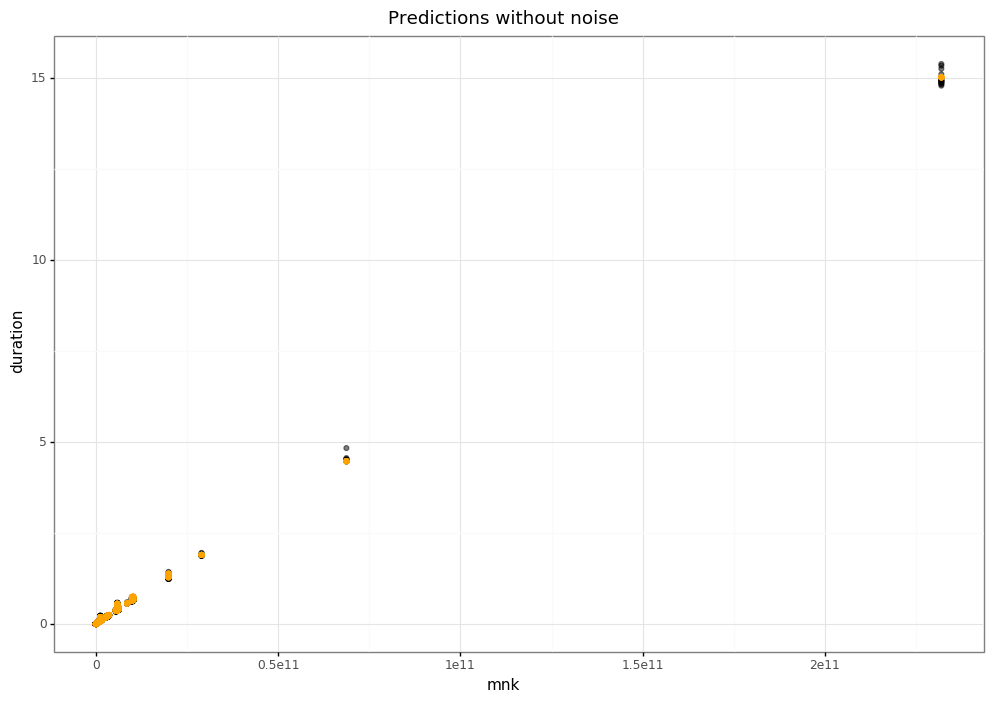

<ggplot: (-9223363279361179718)>


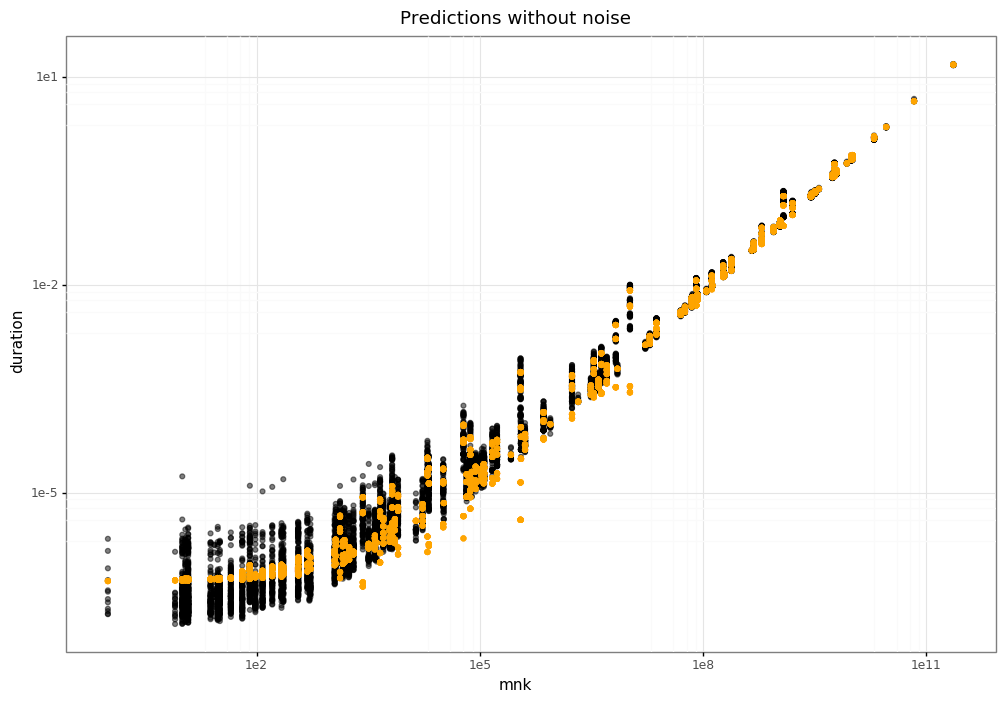

<ggplot: (8757493431346)>


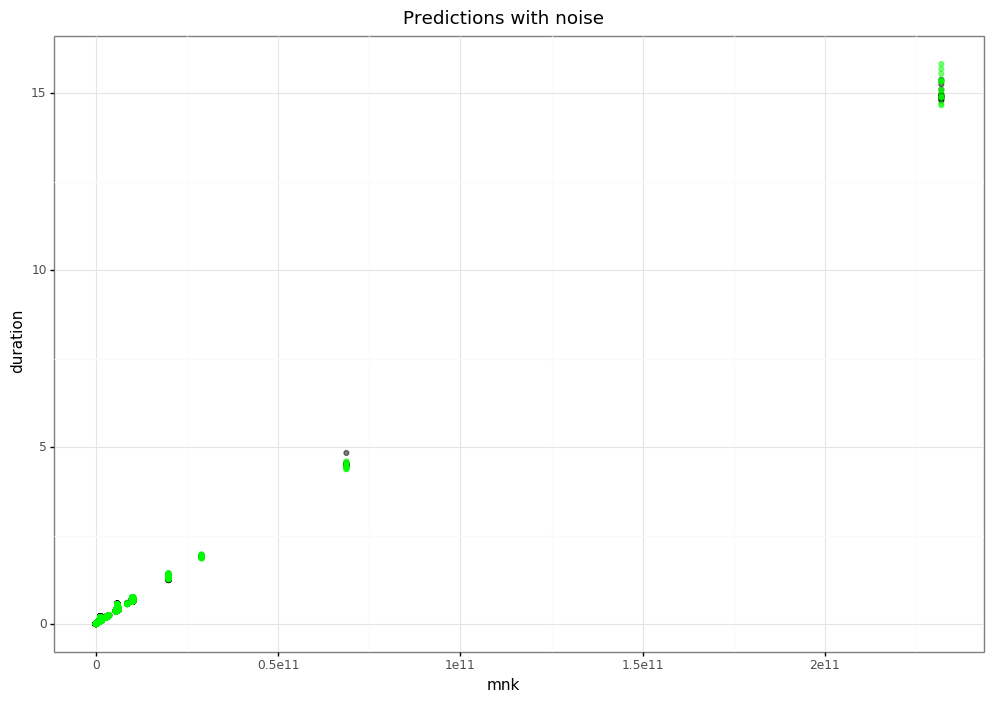

<ggplot: (8757493520020)>


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:549: RuntimeWarning: invalid value encountered in log10
  return self.trans.transform(x)
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 301 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


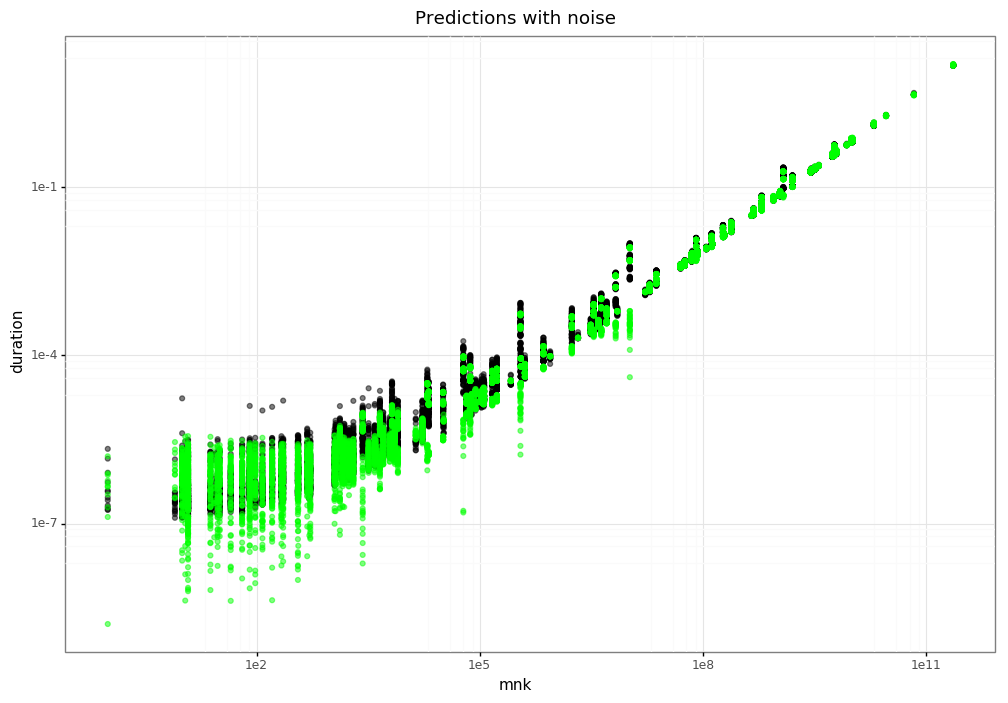

<ggplot: (8757456761839)>
CPU times: user 11.7 s, sys: 6.83 s, total: 18.6 s
Wall time: 15.7 s


{'intercept': 5.250049101142468e-07,
 'mnk': 6.403746939844058e-11,
 'mn': -1.7936484810536843e-10,
 'mk': 1.6043114913171933e-09,
 'nk': 2.9227537833666834e-09,
 'intercept_residual': 6.335008797054781e-07,
 'mnk_residual': 1.204392032551732e-12,
 'mn_residual': -8.597320680190703e-11,
 'mk_residual': -2.2803272852178906e-11,
 'nk_residual': -4.589142867611022e-11}

In [4]:
%time reg_global = compute_full_reg(df, ['mnk', 'mn', 'mk', 'nk'], draw_plot=True, verbose=True)
reg_global

## Linear model

In [5]:
def compute_reg_percpu(df, variables):
    reg_local = []
    for cpu in sorted(df['cpu'].unique()):
        tmp = df[df['cpu'] == cpu] 
        reg = compute_full_reg(tmp, variables)
        reg['node'] = tmp['node'].unique()[0]
        reg['cpu'] = cpu
        reg_local.append(reg)
    return reg_local

reg_local = compute_reg_percpu(df, ['mnk'])
reg_local_pandas = pandas.DataFrame(reg_local).drop(['node', 'cpu'], 1)
reg_local_pandas.describe()

,intercept,intercept_residual,mnk,mnk_residual
count,5.600000e+01,5.600000e+01,5.600000e+01,5.600000e+01
mean,5.198703e-07,6.195940e-07,6.488607e-11,2.806532e-13
std,1.314902e-08,4.762032e-08,1.156880e-12,1.554250e-13
min,4.937630e-07,5.272074e-07,6.370514e-11,1.214231e-13
25%,5.121002e-07,5.832875e-07,6.423067e-11,1.786755e-13
50%,5.179603e-07,6.094661e-07,6.437507e-11,2.075167e-13
75%,5.280410e-07,6.557608e-07,6.496453e-11,3.041252e-13
max,5.451601e-07,7.242937e-07,6.942188e-11,6.870563e-13


In [6]:
def compute_mean_reg(reg):
    mean_reg = {}
    reg = pandas.DataFrame(reg)
    for var in reg.columns:
        mean_reg[var] = reg[var].mean()
    return mean_reg

compute_mean_reg(reg_local)

{'cpu': 34.07142857142857,
 'intercept': 5.198703149801588e-07,
 'intercept_residual': 6.195939558852553e-07,
 'mnk': 6.488606602700189e-11,
 'mnk_residual': 2.8065319125997703e-13,
 'node': 16.785714285714285}

In [7]:
def get_reg(reg, residual):
    if residual:
        reg = {k[:-9]: v for k, v in reg.items() if k.endswith('_residual')}
    else:
        reg = {k: v for k, v in reg.items() if not k.endswith('_residual')}
    return reg
    
def model_str(reg, residual=False):
    reg = get_reg(reg, residual)
    parameters = []
    for name, param in reg.items():
        if param == 0:
            continue
        if name != 'intercept':
            parameters.append('%e*%s' % (param, name))
        else:
            parameters.append('%e' % reg[name])
    return ' + '.join(parameters)

def __return_stmt(reg):
    mu    = model_str(reg, False)
    sigma = model_str(reg, True)
    result  = '        mu    = %s;\n' % mu
    result += '        sigma = %s;\n' % sigma
    result += '        return mu + random_halfnormal_shifted(0, sigma);'
    return result

def __reg_to_c(reg):
    tmp = dict(reg)
    del tmp['cpu']
    del tmp['node']
    return '''    case %d: // node %d\n%s''' % (reg['cpu'], reg['node'], __return_stmt(tmp))

def reg_to_c(all_reg):
    result = [__reg_to_c(reg) for reg in all_reg]
    return '\n'.join(result)

def dump_reg(all_reg):
    reg_code = reg_to_c(all_reg)
    reg_code_default = __return_stmt(compute_mean_reg(all_reg))
    reg_code = 'double mu, sigma;\nswitch(get_cpuid()) {\n%s\n    default:\n%s\n}' % (reg_code, reg_code_default)
    from IPython.display import Markdown, display
    display(Markdown('```c\n%s\n```' % reg_code))

dump_reg(reg_local)

```c
double mu, sigma;
switch(get_cpuid()) {
    case 2: // node 1
        mu    = 5.403580e-07 + 6.749751e-11*mnk;
        sigma = 6.666780e-07 + 6.201119e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 3: // node 1
        mu    = 5.220591e-07 + 6.442078e-11*mnk;
        sigma = 6.982747e-07 + 2.105619e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 4: // node 2
        mu    = 5.276913e-07 + 6.622934e-11*mnk;
        sigma = 6.044271e-07 + 6.007780e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 5: // node 2
        mu    = 5.192003e-07 + 6.479991e-11*mnk;
        sigma = 5.981250e-07 + 3.128629e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 6: // node 3
        mu    = 5.228191e-07 + 6.596774e-11*mnk;
        sigma = 5.833644e-07 + 5.590172e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 7: // node 3
        mu    = 5.071483e-07 + 6.423788e-11*mnk;
        sigma = 5.754146e-07 + 1.658821e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 8: // node 4
        mu    = 5.182449e-07 + 6.436204e-11*mnk;
        sigma = 5.959539e-07 + 2.185985e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 9: // node 4
        mu    = 5.176756e-07 + 6.433753e-11*mnk;
        sigma = 6.224987e-07 + 1.794442e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 10: // node 5
        mu    = 5.127542e-07 + 6.590525e-11*mnk;
        sigma = 5.664282e-07 + 5.765318e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 11: // node 5
        mu    = 5.362046e-07 + 6.403295e-11*mnk;
        sigma = 6.972006e-07 + 1.751985e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 12: // node 6
        mu    = 5.409690e-07 + 6.759847e-11*mnk;
        sigma = 6.312426e-07 + 5.728864e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 13: // node 6
        mu    = 5.032638e-07 + 6.394058e-11*mnk;
        sigma = 5.519080e-07 + 1.578912e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 14: // node 7
        mu    = 5.298281e-07 + 6.477511e-11*mnk;
        sigma = 6.521218e-07 + 2.717915e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 15: // node 7
        mu    = 4.937630e-07 + 6.370514e-11*mnk;
        sigma = 5.272074e-07 + 1.214231e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 16: // node 8
        mu    = 5.441216e-07 + 6.638942e-11*mnk;
        sigma = 6.673456e-07 + 6.870563e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 17: // node 8
        mu    = 5.000922e-07 + 6.441994e-11*mnk;
        sigma = 5.642580e-07 + 1.763696e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 18: // node 9
        mu    = 5.145131e-07 + 6.424284e-11*mnk;
        sigma = 5.899199e-07 + 1.892573e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 19: // node 9
        mu    = 5.049606e-07 + 6.434211e-11*mnk;
        sigma = 6.100888e-07 + 1.863089e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 20: // node 10
        mu    = 5.222622e-07 + 6.430249e-11*mnk;
        sigma = 6.697024e-07 + 1.589611e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 21: // node 10
        mu    = 5.240088e-07 + 6.435981e-11*mnk;
        sigma = 6.504793e-07 + 2.441376e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 22: // node 11
        mu    = 5.027986e-07 + 6.413796e-11*mnk;
        sigma = 5.948043e-07 + 1.486231e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 23: // node 11
        mu    = 5.418981e-07 + 6.620098e-11*mnk;
        sigma = 6.994459e-07 + 4.896485e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 24: // node 12
        mu    = 5.221636e-07 + 6.433978e-11*mnk;
        sigma = 6.667711e-07 + 1.907617e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 25: // node 12
        mu    = 5.256128e-07 + 6.402656e-11*mnk;
        sigma = 6.816091e-07 + 1.864136e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 34: // node 17
        mu    = 5.290902e-07 + 6.709782e-11*mnk;
        sigma = 6.040287e-07 + 5.609182e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 35: // node 17
        mu    = 5.222500e-07 + 6.434971e-11*mnk;
        sigma = 6.385465e-07 + 1.538076e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 36: // node 18
        mu    = 5.446243e-07 + 6.679241e-11*mnk;
        sigma = 7.242937e-07 + 4.584354e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 37: // node 18
        mu    = 4.973578e-07 + 6.423393e-11*mnk;
        sigma = 5.467784e-07 + 2.169178e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 38: // node 19
        mu    = 5.089191e-07 + 6.447933e-11*mnk;
        sigma = 5.694593e-07 + 2.076374e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 39: // node 19
        mu    = 5.322644e-07 + 6.453686e-11*mnk;
        sigma = 6.375594e-07 + 2.034634e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 40: // node 20
        mu    = 5.020687e-07 + 6.452141e-11*mnk;
        sigma = 5.396520e-07 + 1.908164e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 41: // node 20
        mu    = 5.361672e-07 + 6.451670e-11*mnk;
        sigma = 6.692976e-07 + 2.285354e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 42: // node 21
        mu    = 5.300218e-07 + 6.448700e-11*mnk;
        sigma = 6.927166e-07 + 3.012127e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 43: // node 21
        mu    = 5.249067e-07 + 6.432215e-11*mnk;
        sigma = 6.676958e-07 + 2.077369e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 44: // node 22
        mu    = 5.165410e-07 + 6.438809e-11*mnk;
        sigma = 5.997449e-07 + 2.173854e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 45: // node 22
        mu    = 5.150627e-07 + 6.488564e-11*mnk;
        sigma = 5.943844e-07 + 2.095751e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 46: // node 23
        mu    = 5.039400e-07 + 6.445813e-11*mnk;
        sigma = 5.998227e-07 + 1.484263e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 47: // node 23
        mu    = 5.168232e-07 + 6.412272e-11*mnk;
        sigma = 6.163759e-07 + 1.898945e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 48: // node 24
        mu    = 5.151544e-07 + 6.460218e-11*mnk;
        sigma = 5.993471e-07 + 1.953701e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 49: // node 24
        mu    = 5.078540e-07 + 6.410562e-11*mnk;
        sigma = 5.766558e-07 + 1.741955e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 50: // node 25
        mu    = 5.451601e-07 + 6.942188e-11*mnk;
        sigma = 6.490962e-07 + 4.643278e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 51: // node 25
        mu    = 4.997062e-07 + 6.398127e-11*mnk;
        sigma = 5.554807e-07 + 1.608171e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 52: // node 26
        mu    = 5.143945e-07 + 6.458368e-11*mnk;
        sigma = 5.757350e-07 + 1.883528e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 53: // node 26
        mu    = 5.274588e-07 + 6.544914e-11*mnk;
        sigma = 6.413720e-07 + 4.871594e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 54: // node 27
        mu    = 5.258334e-07 + 6.520122e-11*mnk;
        sigma = 6.297259e-07 + 2.920337e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 55: // node 27
        mu    = 5.332343e-07 + 6.567759e-11*mnk;
        sigma = 6.911383e-07 + 4.982782e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 56: // node 28
        mu    = 5.429231e-07 + 6.713744e-11*mnk;
        sigma = 6.893141e-07 + 5.339875e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 57: // node 28
        mu    = 5.134762e-07 + 6.416773e-11*mnk;
        sigma = 6.211102e-07 + 1.756930e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 58: // node 29
        mu    = 5.167773e-07 + 6.420060e-11*mnk;
        sigma = 6.069087e-07 + 1.898162e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 59: // node 29
        mu    = 5.163550e-07 + 6.427940e-11*mnk;
        sigma = 6.359725e-07 + 2.020476e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 60: // node 30
        mu    = 5.174845e-07 + 6.425319e-11*mnk;
        sigma = 6.391262e-07 + 2.784066e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 61: // node 30
        mu    = 5.115994e-07 + 6.416383e-11*mnk;
        sigma = 6.088435e-07 + 1.665847e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 62: // node 31
        mu    = 5.186783e-07 + 6.422089e-11*mnk;
        sigma = 5.830566e-07 + 2.431569e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 63: // node 31
        mu    = 5.122672e-07 + 6.432662e-11*mnk;
        sigma = 5.925127e-07 + 2.035192e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 64: // node 32
        mu    = 5.136935e-07 + 6.396191e-11*mnk;
        sigma = 5.761126e-07 + 2.073960e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 65: // node 32
        mu    = 5.062397e-07 + 6.412149e-11*mnk;
        sigma = 5.601277e-07 + 1.601574e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    default:
        mu    = 3.407143e+01*cpu + 5.198703e-07 + 6.488607e-11*mnk + 1.678571e+01*node;
        sigma = 6.195940e-07 + 2.806532e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
}
```

## Polynomial model

In [8]:
reg_local_poly = compute_reg_percpu(df, ['mnk', 'mn', 'mk', 'nk'])
reg_local_poly_pandas = pandas.DataFrame(reg_local_poly).drop(['node', 'cpu'], 1)
reg_local_poly_pandas.describe()

,intercept,intercept_residual,mk,mk_residual,mn,mn_residual,mnk,mnk_residual,nk,nk_residual
count,5.600000e+01,5.600000e+01,5.600000e+01,5.600000e+01,5.600000e+01,5.600000e+01,5.600000e+01,5.600000e+01,5.600000e+01,5.600000e+01
mean,5.249134e-07,6.060802e-07,1.604311e-09,5.905245e-11,-1.793648e-10,2.927438e-11,6.403747e-11,2.207598e-13,2.922754e-09,5.780894e-11
std,1.203478e-08,3.528488e-08,7.759571e-11,2.525833e-11,1.312940e-10,2.627144e-11,1.193516e-12,1.525233e-13,1.151556e-10,2.578444e-11
min,5.023913e-07,5.343881e-07,1.361118e-09,2.097636e-11,-5.740287e-10,-1.894556e-11,6.283385e-11,6.446655e-14,2.524071e-09,-1.678183e-12
25%,5.155454e-07,5.819738e-07,1.578764e-09,4.595715e-11,-1.859329e-10,1.560322e-11,6.336578e-11,1.195731e-13,2.887959e-09,4.590548e-11
50%,5.232410e-07,6.019840e-07,1.633609e-09,5.113305e-11,-1.201743e-10,2.312030e-11,6.350534e-11,1.501578e-13,2.961947e-09,5.708893e-11
75%,5.318679e-07,6.392430e-07,1.653668e-09,5.660566e-11,-9.860784e-11,3.082770e-11,6.410128e-11,2.513209e-13,3.001537e-09,6.335792e-11
max,5.552318e-07,6.733427e-07,1.704904e-09,1.347495e-10,-4.793847e-11,1.124913e-10,6.861468e-11,6.229879e-13,3.090069e-09,1.540899e-10


In [9]:
dump_reg(reg_local_poly)

```c
double mu, sigma;
switch(get_cpuid()) {
    case 2: // node 1
        mu    = 5.393244e-07 + 6.679759e-11*mnk + -5.740287e-10*mn + 1.361118e-09*mk + 2.524071e-09*nk;
        sigma = 6.433163e-07 + 5.372149e-13*mnk + 1.009451e-10*mn + 1.347495e-10*mk + 9.457558e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 3: // node 1
        mu    = 5.228051e-07 + 6.355150e-11*mnk + -1.334303e-10*mn + 1.660894e-09*mk + 2.965415e-09*nk;
        sigma = 6.225043e-07 + 1.505842e-13*mnk + 1.976500e-11*mn + 5.622314e-11*mk + 5.870116e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 4: // node 2
        mu    = 5.329919e-07 + 6.547159e-11*mnk + -4.171307e-10*mn + 1.428695e-09*mk + 2.710319e-09*nk;
        sigma = 5.876532e-07 + 5.512897e-13*mnk + 1.152215e-11*mn + 4.975200e-11*mk + 1.887183e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 5: // node 2
        mu    = 5.262917e-07 + 6.392687e-11*mnk + -1.616727e-10*mn + 1.650467e-09*mk + 3.011181e-09*nk;
        sigma = 6.142762e-07 + 2.554112e-13*mnk + 1.792774e-11*mn + 5.265701e-11*mk + 6.082794e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 6: // node 3
        mu    = 5.305164e-07 + 6.518867e-11*mnk + -3.740277e-10*mn + 1.458767e-09*mk + 2.779049e-09*nk;
        sigma = 5.923702e-07 + 5.100048e-13*mnk + 1.189282e-11*mn + 4.741327e-11*mk + 2.357065e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 7: // node 3
        mu    = 5.136505e-07 + 6.335566e-11*mnk + -9.740071e-11*mn + 1.678005e-09*mk + 3.002629e-09*nk;
        sigma = 5.874046e-07 + 1.061984e-13*mnk + 3.339540e-11*mn + 5.059355e-11*mk + 5.858528e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 8: // node 4
        mu    = 5.230183e-07 + 6.349091e-11*mnk + -1.267585e-10*mn + 1.641870e-09*mk + 2.988689e-09*nk;
        sigma = 5.810166e-07 + 1.627549e-13*mnk + 1.344342e-11*mn + 4.505368e-11*mk + 5.126023e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 9: // node 4
        mu    = 5.268878e-07 + 6.345320e-11*mnk + -9.948909e-11*mn + 1.677894e-09*mk + 3.011612e-09*nk;
        sigma = 6.407215e-07 + 1.201509e-13*mnk + 1.953734e-11*mn + 4.503107e-11*mk + 6.347004e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 10: // node 5
        mu    = 5.190615e-07 + 6.509485e-11*mnk + -3.173703e-10*mn + 1.548433e-09*mk + 2.821357e-09*nk;
        sigma = 5.844281e-07 + 5.236558e-13*mnk + 2.361859e-11*mn + 7.380883e-11*mk + 2.018451e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 11: // node 5
        mu    = 5.322948e-07 + 6.316829e-11*mnk + -8.666260e-11*mn + 1.632169e-09*mk + 2.940922e-09*nk;
        sigma = 6.321226e-07 + 1.153900e-13*mnk + 2.645732e-11*mn + 5.564334e-11*mk + 6.106570e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 12: // node 6
        mu    = 5.491498e-07 + 6.680856e-11*mnk + -3.753763e-10*mn + 1.526969e-09*mk + 2.762434e-09*nk;
        sigma = 6.274122e-07 + 4.870974e-13*mnk + 1.094427e-10*mn + 1.206953e-10*mk + 1.335707e-10*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 13: // node 6
        mu    = 5.087136e-07 + 6.307483e-11*mnk + -8.990279e-11*mn + 1.624337e-09*mk + 2.954883e-09*nk;
        sigma = 5.362213e-07 + 9.875785e-14*mnk + 2.516824e-11*mn + 5.463920e-11*mk + 5.663861e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 14: // node 7
        mu    = 5.385376e-07 + 6.388876e-11*mnk + -1.085675e-10*mn + 1.675846e-09*mk + 3.031570e-09*nk;
        sigma = 6.471845e-07 + 2.144037e-13*mnk + 2.056132e-11*mn + 5.775322e-11*mk + 5.753924e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 15: // node 7
        mu    = 5.023913e-07 + 6.283385e-11*mnk + -7.262560e-11*mn + 1.620455e-09*mk + 2.983781e-09*nk;
        sigma = 5.343881e-07 + 6.446655e-14*mnk + 1.798127e-11*mn + 4.872682e-11*mk + 5.032753e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 16: // node 8
        mu    = 5.492241e-07 + 6.559519e-11*mnk + -3.770104e-10*mn + 1.502750e-09*mk + 2.812904e-09*nk;
        sigma = 6.733427e-07 + 6.229879e-13*mnk + 4.653663e-11*mn + 8.707011e-11*mk + 7.255564e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 17: // node 8
        mu    = 5.076557e-07 + 6.356987e-11*mnk + -1.366242e-10*mn + 1.606765e-09*mk + 2.910988e-09*nk;
        sigma = 5.655804e-07 + 1.143208e-13*mnk + 3.147357e-11*mn + 6.516342e-11*mk + 6.524439e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 18: // node 9
        mu    = 5.231685e-07 + 6.338601e-11*mnk + -1.199330e-10*mn + 1.610505e-09*mk + 2.934597e-09*nk;
        sigma = 5.964673e-07 + 1.313353e-13*mnk + 1.937225e-11*mn + 5.018231e-11*mk + 5.910065e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 19: // node 9
        mu    = 5.153587e-07 + 6.348720e-11*mnk + -1.204156e-10*mn + 1.616533e-09*mk + 2.919605e-09*nk;
        sigma = 5.959051e-07 + 1.323522e-13*mnk + 1.580925e-11*mn + 4.237050e-11*mk + 4.294049e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 20: // node 10
        mu    = 5.261699e-07 + 6.340284e-11*mnk + -7.340727e-11*mn + 1.700672e-09*mk + 3.057443e-09*nk;
        sigma = 6.469882e-07 + 9.669903e-14*mnk + 2.882459e-11*mn + 5.589685e-11*mk + 6.332054e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 21: // node 10
        mu    = 5.288127e-07 + 6.348381e-11*mnk + -1.028025e-10*mn + 1.654537e-09*mk + 2.993711e-09*nk;
        sigma = 6.169246e-07 + 1.914430e-13*mnk + 9.911284e-12*mn + 3.664809e-11*mk + 4.506676e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 22: // node 11
        mu    = 5.092075e-07 + 6.326350e-11*mnk + -1.004866e-10*mn + 1.643766e-09*mk + 2.990651e-09*nk;
        sigma = 5.726342e-07 + 8.739050e-14*mnk + 2.996774e-11*mn + 5.202909e-11*mk + 6.606632e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 23: // node 11
        mu    = 5.414760e-07 + 6.543216e-11*mnk + -4.190672e-10*mn + 1.443803e-09*mk + 2.748622e-09*nk;
        sigma = 6.561465e-07 + 4.284506e-13*mnk + 3.240033e-11*mn + 8.273599e-11*mk + 4.048271e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 24: // node 12
        mu    = 5.233135e-07 + 6.347770e-11*mnk + -1.191088e-10*mn + 1.609964e-09*mk + 2.962635e-09*nk;
        sigma = 6.099668e-07 + 1.356748e-13*mnk + 1.498512e-11*mn + 3.918575e-11*mk + 5.127312e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 25: // node 12
        mu    = 5.265666e-07 + 6.314147e-11*mnk + -7.996460e-11*mn + 1.666515e-09*mk + 3.016302e-09*nk;
        sigma = 6.399890e-07 + 1.269028e-13*mnk + 2.240832e-11*mn + 5.539865e-11*mk + 6.012762e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 34: // node 17
        mu    = 5.344454e-07 + 6.632775e-11*mnk + -4.274161e-10*mn + 1.470139e-09*mk + 2.724523e-09*nk;
        sigma = 6.004602e-07 + 4.813531e-13*mnk + 9.119124e-11*mn + 1.183724e-10*mk + 9.917033e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 35: // node 17
        mu    = 5.299293e-07 + 6.346425e-11*mnk + -1.259036e-10*mn + 1.688626e-09*mk + 3.017974e-09*nk;
        sigma = 6.198819e-07 + 8.841592e-14*mnk + 3.248806e-11*mn + 7.237567e-11*mk + 6.760120e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 36: // node 18
        mu    = 5.468983e-07 + 6.601110e-11*mnk + -3.807323e-10*mn + 1.516048e-09*mk + 2.725249e-09*nk;
        sigma = 6.586774e-07 + 3.790927e-13*mnk + 8.682976e-11*mn + 1.253534e-10*mk + 9.683318e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 37: // node 18
        mu    = 5.067599e-07 + 6.338941e-11*mnk + -1.350813e-10*mn + 1.585363e-09*mk + 2.898263e-09*nk;
        sigma = 5.465379e-07 + 1.575142e-13*mnk + 3.449688e-11*mn + 5.544574e-11*mk + 6.214726e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 38: // node 19
        mu    = 5.134214e-07 + 6.359606e-11*mnk + -9.901022e-11*mn + 1.663628e-09*mk + 3.018796e-09*nk;
        sigma = 5.640162e-07 + 1.511667e-13*mnk + 1.290475e-11*mn + 4.780033e-11*mk + 5.015694e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 39: // node 19
        mu    = 5.368837e-07 + 6.368006e-11*mnk + -1.479424e-10*mn + 1.619711e-09*mk + 2.943221e-09*nk;
        sigma = 6.391290e-07 + 1.483428e-13*mnk + 1.138776e-11*mn + 4.142007e-11*mk + 5.003563e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 40: // node 20
        mu    = 5.103642e-07 + 6.364136e-11*mnk + -1.178451e-10*mn + 1.662917e-09*mk + 3.007687e-09*nk;
        sigma = 5.788666e-07 + 1.313219e-13*mnk + 1.878462e-11*mn + 5.025264e-11*mk + 6.374513e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 41: // node 20
        mu    = 5.397179e-07 + 6.364649e-11*mnk + -1.123143e-10*mn + 1.636110e-09*mk + 2.979555e-09*nk;
        sigma = 6.508375e-07 + 1.720763e-13*mnk + 2.220993e-11*mn + 4.467521e-11*mk + 6.062142e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 42: // node 21
        mu    = 5.317256e-07 + 6.358211e-11*mnk + -9.284797e-11*mn + 1.704904e-09*mk + 3.090069e-09*nk;
        sigma = 6.667179e-07 + 2.499575e-13*mnk + 6.779641e-12*mn + 3.445108e-11*mk + 4.021661e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 43: // node 21
        mu    = 5.208321e-07 + 6.345914e-11*mnk + -1.326302e-10*mn + 1.636123e-09*mk + 2.953639e-09*nk;
        sigma = 6.146244e-07 + 1.502692e-13*mnk + 2.977270e-11*mn + 4.805156e-11*mk + 4.482061e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 44: // node 22
        mu    = 5.231029e-07 + 6.351977e-11*mnk + -1.002971e-10*mn + 1.636146e-09*mk + 2.961246e-09*nk;
        sigma = 6.013081e-07 + 1.572541e-13*mnk + 3.333609e-11*mn + 5.910749e-11*mk + 6.083720e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 45: // node 22
        mu    = 5.206402e-07 + 6.401250e-11*mnk + -1.391267e-10*mn + 1.648974e-09*mk + 2.997566e-09*nk;
        sigma = 6.026599e-07 + 1.485980e-13*mnk + 2.262201e-11*mn + 6.262390e-11*mk + 5.576603e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 46: // node 23
        mu    = 5.064498e-07 + 6.357593e-11*mnk + -1.127577e-10*mn + 1.665394e-09*mk + 3.018353e-09*nk;
        sigma = 5.660005e-07 + 8.699292e-14*mnk + 2.742789e-11*mn + 5.041331e-11*mk + 6.274031e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 47: // node 23
        mu    = 5.190310e-07 + 6.327078e-11*mnk + -1.248876e-10*mn + 1.598032e-09*mk + 2.924428e-09*nk;
        sigma = 5.859136e-07 + 1.349920e-13*mnk + 1.862309e-11*mn + 4.806724e-11*mk + 4.257829e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 48: // node 24
        mu    = 5.185796e-07 + 6.373260e-11*mnk + -1.265035e-10*mn + 1.636102e-09*mk + 2.981898e-09*nk;
        sigma = 5.812255e-07 + 1.344772e-13*mnk + 2.544243e-11*mn + 5.397706e-11*mk + 6.632500e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 49: // node 24
        mu    = 5.156076e-07 + 6.323151e-11*mnk + -8.437938e-11*mn + 1.645000e-09*mk + 2.975996e-09*nk;
        sigma = 5.615274e-07 + 1.125446e-13*mnk + 3.573403e-11*mn + 5.190488e-11*mk + 6.109547e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 50: // node 25
        mu    = 5.552318e-07 + 6.861468e-11*mnk + -3.886047e-10*mn + 1.558966e-09*mk + 2.812087e-09*nk;
        sigma = 6.491666e-07 + 3.717752e-13*mnk + 1.124913e-10*mn + 1.229869e-10*mk + 1.540899e-10*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 51: // node 25
        mu    = 5.071344e-07 + 6.314591e-11*mnk + -1.394035e-10*mn + 1.555916e-09*mk + 2.884728e-09*nk;
        sigma = 5.456455e-07 + 1.090036e-13*mnk + 1.235565e-11*mn + 4.115298e-11*mk + 3.147907e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 52: // node 26
        mu    = 5.220811e-07 + 6.371916e-11*mnk + -1.606740e-10*mn + 1.626739e-09*mk + 2.978407e-09*nk;
        sigma = 5.822232e-07 + 1.300913e-13*mnk + 1.807460e-11*mn + 5.077949e-11*mk + 5.385897e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 53: // node 26
        mu    = 5.305365e-07 + 6.465317e-11*mnk + -3.202027e-10*mn + 1.499278e-09*mk + 2.807434e-09*nk;
        sigma = 6.062084e-07 + 4.480827e-13*mnk + -1.894556e-11*mn + 2.097636e-11*mk + -1.678183e-12*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 54: // node 27
        mu    = 5.365141e-07 + 6.436760e-11*mnk + -2.587134e-10*mn + 1.593261e-09*mk + 2.889037e-09*nk;
        sigma = 6.655126e-07 + 2.345591e-13*mnk + 1.103735e-11*mn + 5.334813e-11*mk + 4.773279e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 55: // node 27
        mu    = 5.276706e-07 + 6.489361e-11*mnk + -3.601891e-10*mn + 1.483759e-09*mk + 2.775141e-09*nk;
        sigma = 6.297032e-07 + 4.511767e-13*mnk + -6.907262e-13*mn + 5.045010e-11*mk + 9.056070e-12*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 56: // node 28
        mu    = 5.420053e-07 + 6.639338e-11*mnk + -4.974038e-10*mn + 1.459098e-09*mk + 2.628189e-09*nk;
        sigma = 6.476256e-07 + 4.507555e-13*mnk + 8.780899e-11*mn + 1.246792e-10*mk + 1.119746e-10*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 57: // node 28
        mu    = 5.149328e-07 + 6.328837e-11*mnk + -9.665357e-11*mn + 1.646485e-09*mk + 3.013190e-09*nk;
        sigma = 5.893493e-07 + 1.178396e-13*mnk + 2.461958e-11*mn + 5.148661e-11*mk + 4.889745e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 58: // node 29
        mu    = 5.255900e-07 + 6.331282e-11*mnk + -6.500140e-11*mn + 1.688902e-09*mk + 3.001173e-09*nk;
        sigma = 6.195277e-07 + 1.295266e-13*mnk + 3.061241e-11*mn + 4.846374e-11*mk + 5.632437e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 59: // node 29
        mu    = 5.208931e-07 + 6.339989e-11*mnk + -1.045580e-10*mn + 1.645969e-09*mk + 3.019445e-09*nk;
        sigma = 6.126106e-07 + 1.432108e-13*mnk + 2.656993e-11*mn + 5.149211e-11*mk + 5.389626e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 60: // node 30
        mu    = 5.265286e-07 + 6.337573e-11*mnk + -7.189099e-11*mn + 1.656573e-09*mk + 2.979553e-09*nk;
        sigma = 6.395850e-07 + 2.261061e-13*mnk + 1.316460e-11*mn + 4.184614e-11*mk + 5.221730e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 61: // node 30
        mu    = 5.145376e-07 + 6.328963e-11*mnk + -1.051588e-10*mn + 1.635049e-09*mk + 3.000886e-09*nk;
        sigma = 5.647746e-07 + 1.054263e-13*mnk + 2.836230e-11*mn + 5.204211e-11*mk + 6.824112e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 62: // node 31
        mu    = 5.255507e-07 + 6.336915e-11*mnk + -1.155430e-10*mn + 1.603461e-09*mk + 2.916228e-09*nk;
        sigma = 5.942084e-07 + 1.902949e-13*mnk + 1.780135e-11*mn + 4.575905e-11*mk + 4.315604e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 63: // node 31
        mu    = 5.203696e-07 + 6.345565e-11*mnk + -9.089474e-11*mn + 1.650291e-09*mk + 2.961259e-09*nk;
        sigma = 5.969045e-07 + 1.500465e-13*mnk + 1.293906e-11*mn + 4.133834e-11*mk + 4.200090e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 64: // node 32
        mu    = 5.231576e-07 + 6.307634e-11*mnk + -4.793847e-11*mn + 1.653379e-09*mk + 3.015021e-09*nk;
        sigma = 5.847438e-07 + 1.510827e-13*mnk + 2.488421e-11*mn + 4.040013e-11*mk + 5.981118e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 65: // node 32
        mu    = 5.114425e-07 + 6.325749e-11*mnk + -7.866192e-11*mn + 1.629375e-09*mk + 2.938603e-09*nk;
        sigma = 5.693536e-07 + 1.042669e-13*mnk + 2.490204e-11*mn + 4.602318e-11*mk + 4.618505e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    default:
        mu    = 3.407143e+01*cpu + 5.249134e-07 + 1.604311e-09*mk + -1.793648e-10*mn + 6.403747e-11*mnk + 2.922754e-09*nk + 1.678571e+01*node;
        sigma = 6.060802e-07 + 5.905245e-11*mk + 2.927438e-11*mn + 2.207598e-13*mnk + 5.780894e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
}
```

### Visualization (linear model)

In [10]:
def compute_predictions(df, reg_local, variables):
    for reg in reg_local:
        tmp = df[df['cpu'] == reg['cpu']]
        reg_duration = get_reg(reg, residual=False)
        df.loc[df['cpu'] == reg['cpu'], 'prediction'] = predict(tmp, reg_duration, variables)
        reg_residual = get_reg(reg, residual=True)
        df.loc[df['cpu'] == reg['cpu'], 'sd_noise'] = predict(tmp, reg_residual, variables)
    df['sigma'] = df['sd_noise']/numpy.sqrt(1-2/numpy.pi)
    df['mu'] = -df['sigma']*numpy.sqrt(2/numpy.pi)
    df['noise'] = numpy.abs(numpy.random.normal(0, 1, len(df)))
    df['noise'] *= df['sigma']
    df['noise'] += df['mu']
    df['pred_noise'] = df['prediction'] + df['noise']

compute_predictions(df, reg_local, ['mnk'])
df.head()

,function,m,n,k,timestamp,duration,node,index,index_in_seq,first_index,...,mnk,mn,mk,nk,prediction,sd_noise,sigma,mu,noise,pred_noise
1200000,dgemm,231,95,8496,3408.439356,0.018992,26,0,0,True,...,186444720,21945,1962576,807120,0.012042,0.000036,0.000059,-0.000047,-0.000012,0.012030
1200001,dgemm,231,95,8496,3408.458369,0.018742,26,1,1,False,...,186444720,21945,1962576,807120,0.012042,0.000036,0.000059,-0.000047,0.000015,0.012056
1200002,dgemm,231,95,8496,3408.477118,0.018643,26,2,2,False,...,186444720,21945,1962576,807120,0.012042,0.000036,0.000059,-0.000047,-0.000041,0.012001
1200003,dgemm,1070,276,3012,3408.495768,0.064044,26,3,0,True,...,889503840,295320,3222840,831312,0.057448,0.000168,0.000279,-0.000223,0.000059,0.057507
1200004,dgemm,1070,276,3012,3408.559819,0.064706,26,4,1,False,...,889503840,295320,3222840,831312,0.057448,0.000168,0.000279,-0.000223,-0.000188,0.057259


In [11]:
tmp = df.melt(id_vars=['cpu', 'node', 'mnk'], value_vars=['duration', 'pred_noise'])
tmp.head()

,cpu,node,mnk,variable,value
0,52,26,186444720,duration,0.018992
1,52,26,186444720,duration,0.018742
2,52,26,186444720,duration,0.018643
3,52,26,889503840,duration,0.064044
4,52,26,889503840,duration,0.064706


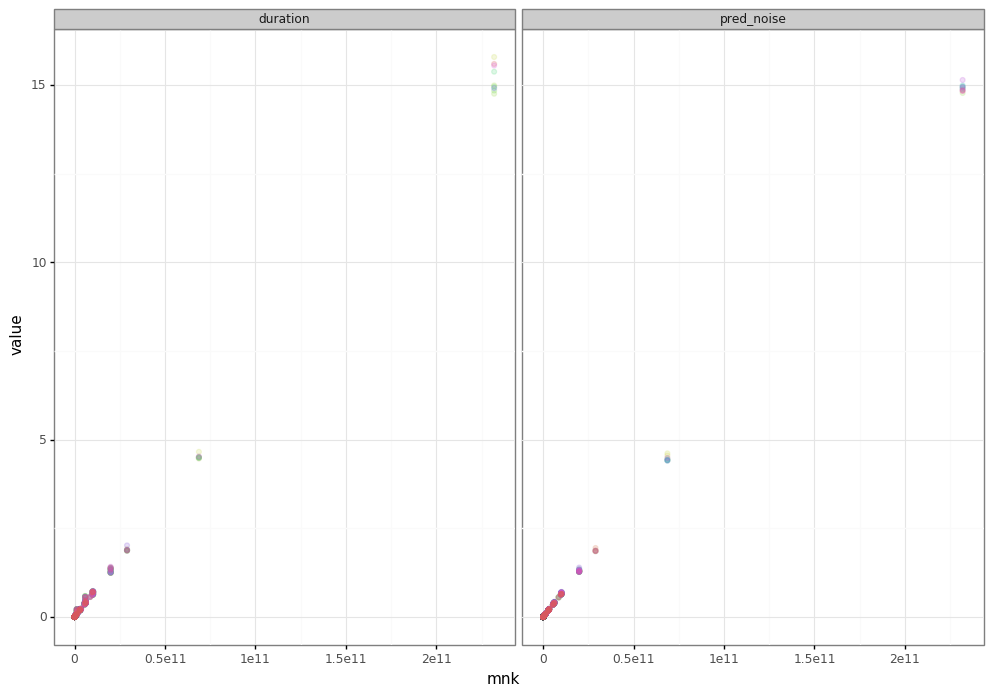

<ggplot: (8757456680175)>


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:549: RuntimeWarning: invalid value encountered in log10
  return self.trans.transform(x)
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 283 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


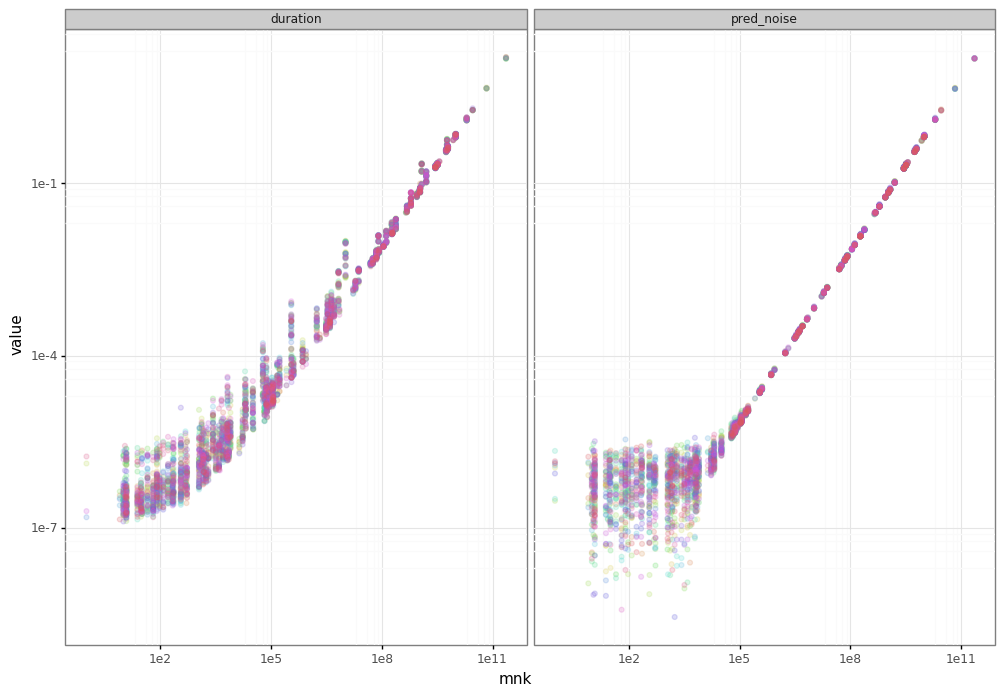

<ggplot: (-9223363279398391857)>


In [12]:
plot = ggplot(tmp.sample(n=10000), aes(x='mnk', y='value', color='factor(cpu)')) + geom_point(alpha=0.2) + theme_bw() + facet_wrap('variable') + scale_color_discrete(guide=False)
print(plot)
print(plot + scale_x_log10() + scale_y_log10())

### Visualization (polynomial model)

In [13]:
compute_predictions(df, reg_local_poly, ['mnk', 'mn', 'mk', 'nk'])
df.head()

,function,m,n,k,timestamp,duration,node,index,index_in_seq,first_index,...,mnk,mn,mk,nk,prediction,sd_noise,sigma,mu,noise,pred_noise
1200000,dgemm,231,95,8496,3408.439356,0.018992,26,0,0,True,...,186444720,21945,1962576,807120,0.017474,0.000168,0.000279,-0.000223,0.000298,0.017772
1200001,dgemm,231,95,8496,3408.458369,0.018742,26,1,1,False,...,186444720,21945,1962576,807120,0.017474,0.000168,0.000279,-0.000223,-0.000180,0.017293
1200002,dgemm,231,95,8496,3408.477118,0.018643,26,2,2,False,...,186444720,21945,1962576,807120,0.017474,0.000168,0.000279,-0.000223,0.000096,0.017569
1200003,dgemm,1070,276,3012,3408.495768,0.064044,26,3,0,True,...,889503840,295320,3222840,831312,0.064350,0.000330,0.000548,-0.000437,0.000063,0.064413
1200004,dgemm,1070,276,3012,3408.559819,0.064706,26,4,1,False,...,889503840,295320,3222840,831312,0.064350,0.000330,0.000548,-0.000437,-0.000232,0.064118


In [14]:
tmp = df.melt(id_vars=['cpu', 'node', 'mnk'], value_vars=['duration', 'pred_noise'])
tmp.head()

,cpu,node,mnk,variable,value
0,52,26,186444720,duration,0.018992
1,52,26,186444720,duration,0.018742
2,52,26,186444720,duration,0.018643
3,52,26,889503840,duration,0.064044
4,52,26,889503840,duration,0.064706


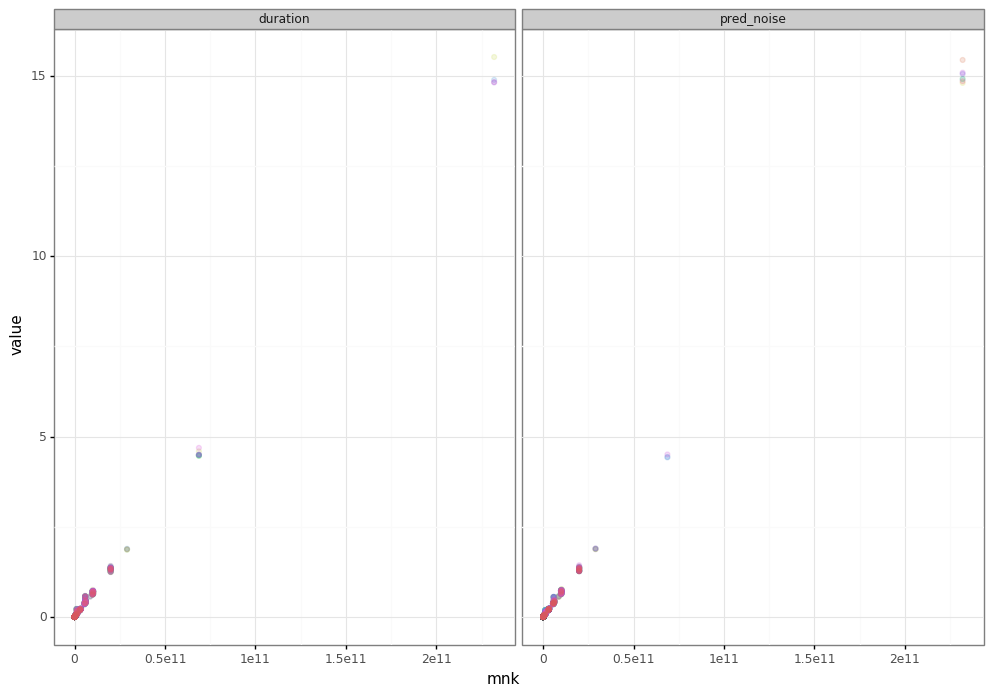

<ggplot: (8757446731349)>


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:549: RuntimeWarning: invalid value encountered in log10
  return self.trans.transform(x)
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 148 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


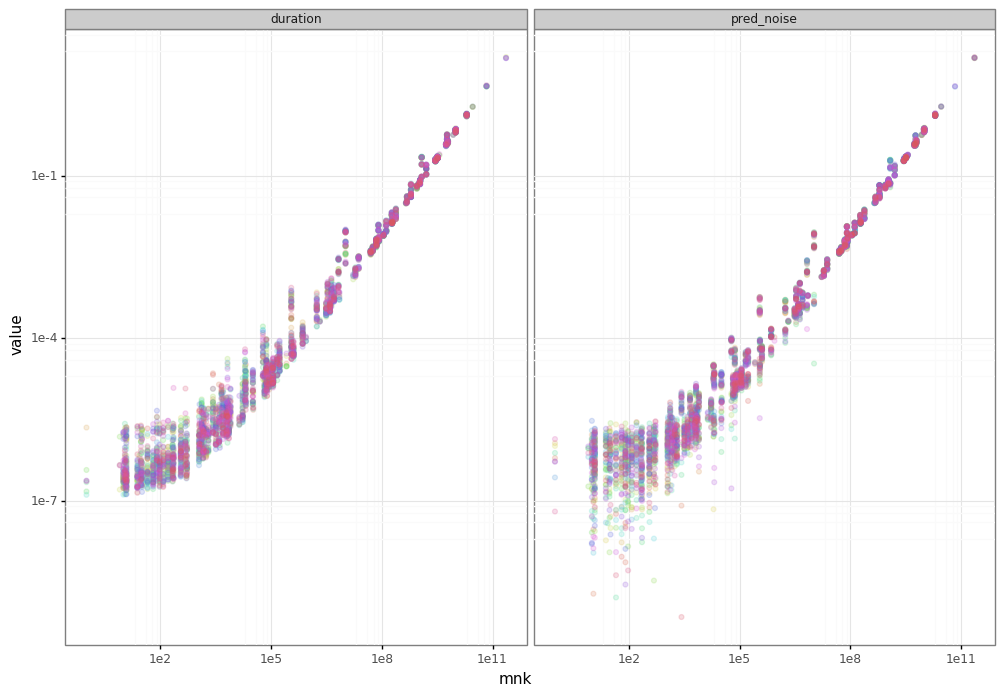

<ggplot: (8757446505294)>


In [15]:
plot = ggplot(tmp.sample(n=10000), aes(x='mnk', y='value', color='factor(cpu)')) + geom_point(alpha=0.2) + theme_bw() + facet_wrap('variable') + scale_color_discrete(guide=False)
print(plot)
print(plot + scale_x_log10() + scale_y_log10())

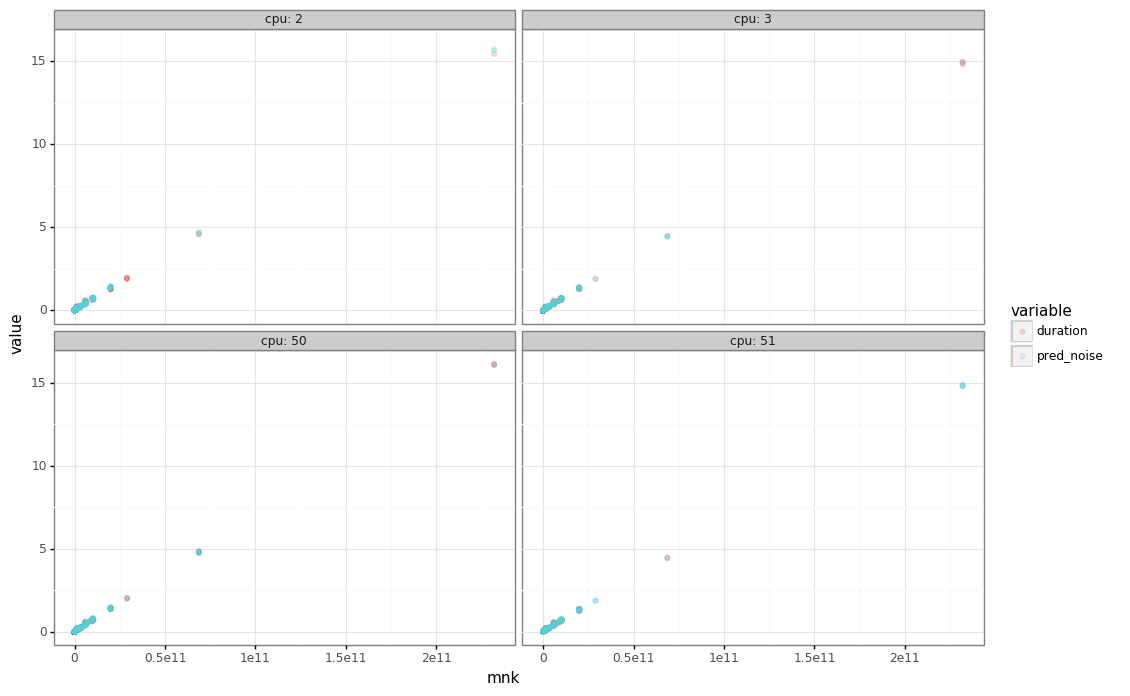

<ggplot: (-9223363279407861444)>


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:549: RuntimeWarning: invalid value encountered in log10
  return self.trans.transform(x)
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 186 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


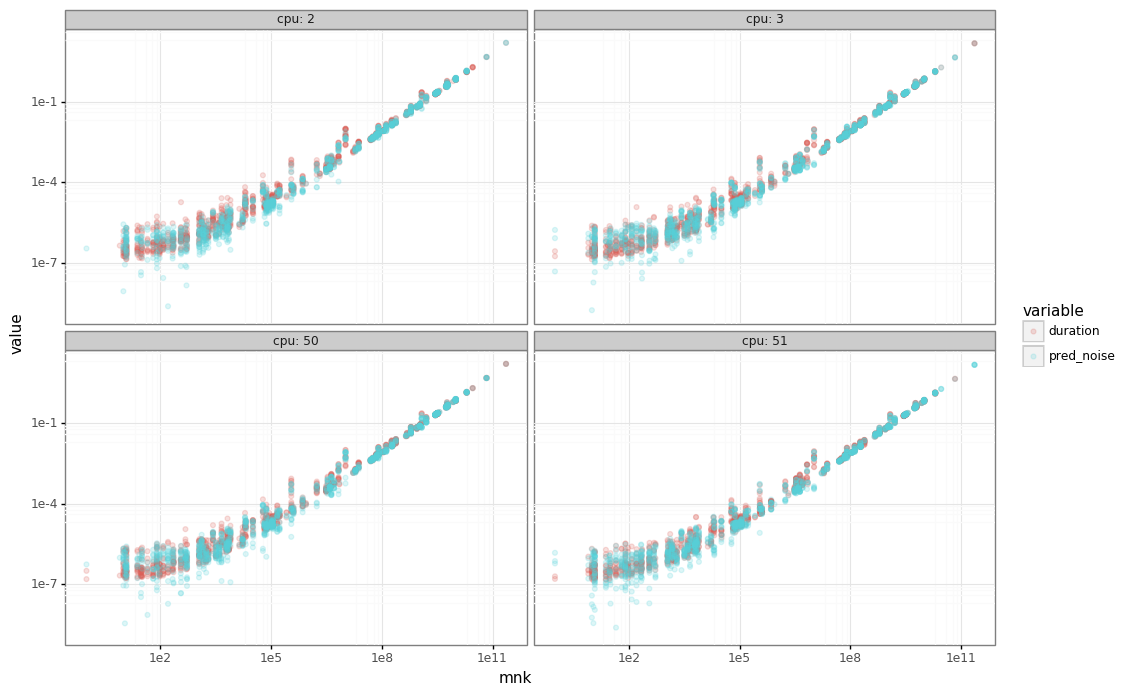

<ggplot: (-9223363279361307006)>


In [16]:
plot = ggplot(tmp[tmp.node.isin([1, 25])].sample(n=10000), aes(x='mnk', y='value', color='variable')) + geom_point(alpha=0.2) + theme_bw()
plot = plot + facet_wrap('cpu', labeller='label_both')
print(plot)
print(plot + scale_x_log10() + scale_y_log10())

### Validation of the polynomial model on HPL data

In [17]:
hpl_archive = '../hpl/grenoble_2019-03-28_1856800.zip'
sizes = list(read_csv(hpl_archive, 'results.csv').matrix_size)

blas_col = ['file', 'line', 'function', 'rank', 'timestamp', 'duration', 'm', 'n', 'k']
hpl_dgemm = []
for i, size in enumerate(sizes):
    blas_trace = read_csv(hpl_archive, 'trace_blas_%d.csv' % i, columns=blas_col)
    blas_trace = blas_trace[(blas_trace['m'] != 0) & (blas_trace['n'] != 0) & (blas_trace['k'] != 0)]
    blas_trace['function'] = blas_trace['function'].str.strip()
    blas_trace = blas_trace[blas_trace['function'] == 'dgemm']
    hpl_dgemm.append(blas_trace)
hpl_dgemm = pandas.concat(hpl_dgemm)

df['origin'] = 'calibration'
hpl_dgemm['origin'] = 'HPL'
hpl_dgemm['size_product'] = hpl_dgemm.m * hpl_dgemm.n * hpl_dgemm.k

In [18]:
hpl_dgemm['mnk'] = hpl_dgemm.m * hpl_dgemm.n * hpl_dgemm.k
hpl_dgemm['mn'] = hpl_dgemm.m * hpl_dgemm.n
hpl_dgemm['mk'] = hpl_dgemm.m * hpl_dgemm.k
hpl_dgemm['nk'] = hpl_dgemm.n * hpl_dgemm.k

# The following supposes that HPL was executed on dahu-{1, 2, 3, ...} and that the ranks were mapped in order
hpl_dgemm['core'] = hpl_dgemm['rank']
hpl_dgemm['node'] = 1 + hpl_dgemm['rank'] // 32
hpl_dgemm['cpu'] = 2*hpl_dgemm['node'] + hpl_dgemm['core']%2

In [19]:
compute_predictions(hpl_dgemm, reg_local_poly, ['mnk', 'mn', 'mk', 'nk'])
hpl_dgemm.head()

,file,line,function,rank,timestamp,duration,m,n,k,origin,...,nk,core,node,cpu,prediction,sd_noise,sigma,mu,noise,pred_noise
13,../HPL_pdrpanrlT.c,224,dgemm,0,14.47309,0.000200,50046.0,2.0,2.0,HPL,...,4.0,0,1,2,0.000093,0.000024,0.00004,-0.000032,3.786719e-05,0.000131
29,../HPL_pdrpanrlT.c,224,dgemm,0,14.47358,0.000380,50044.0,4.0,4.0,HPL,...,16.0,0,1,2,0.000212,0.000048,0.00008,-0.000064,-3.718702e-05,0.000174
43,../HPL_pdrpanrlT.c,224,dgemm,0,14.47421,0.000166,50042.0,2.0,2.0,HPL,...,4.0,0,1,2,0.000093,0.000024,0.00004,-0.000032,-6.411452e-07,0.000092
66,../HPL_pdrpanrlT.c,224,dgemm,0,14.47468,0.000751,50040.0,8.0,8.0,HPL,...,64.0,0,1,2,0.000530,0.000097,0.00016,-0.000128,-1.182749e-04,0.000411
81,../HPL_pdrpanrlT.c,224,dgemm,0,14.47579,0.000177,50038.0,2.0,2.0,HPL,...,4.0,0,1,2,0.000093,0.000024,0.00004,-0.000032,2.590300e-05,0.000119


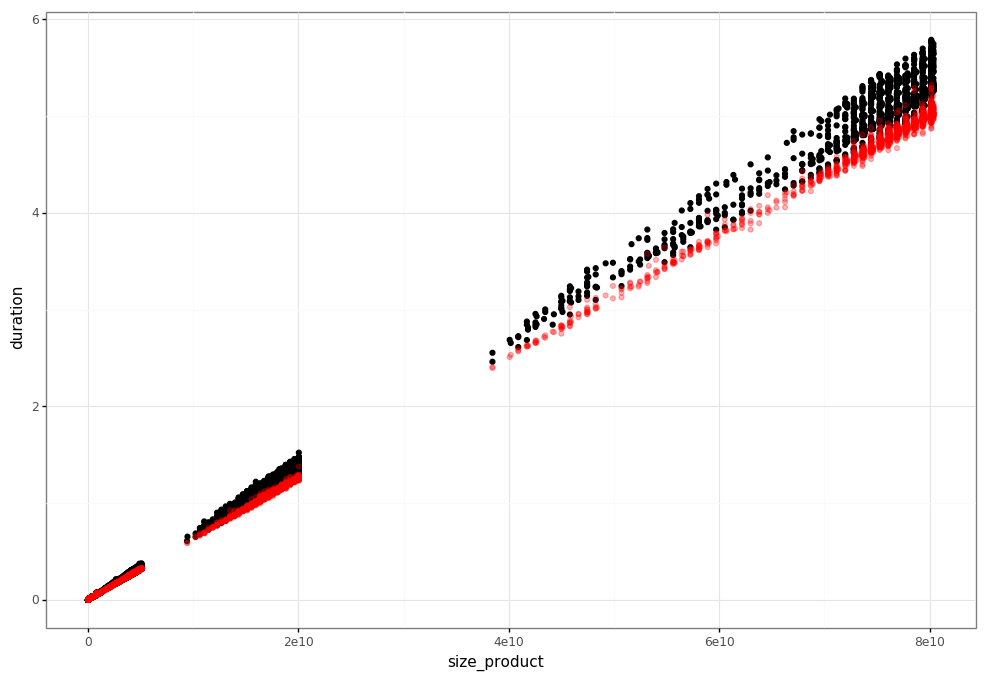

<ggplot: (8757493370593)>


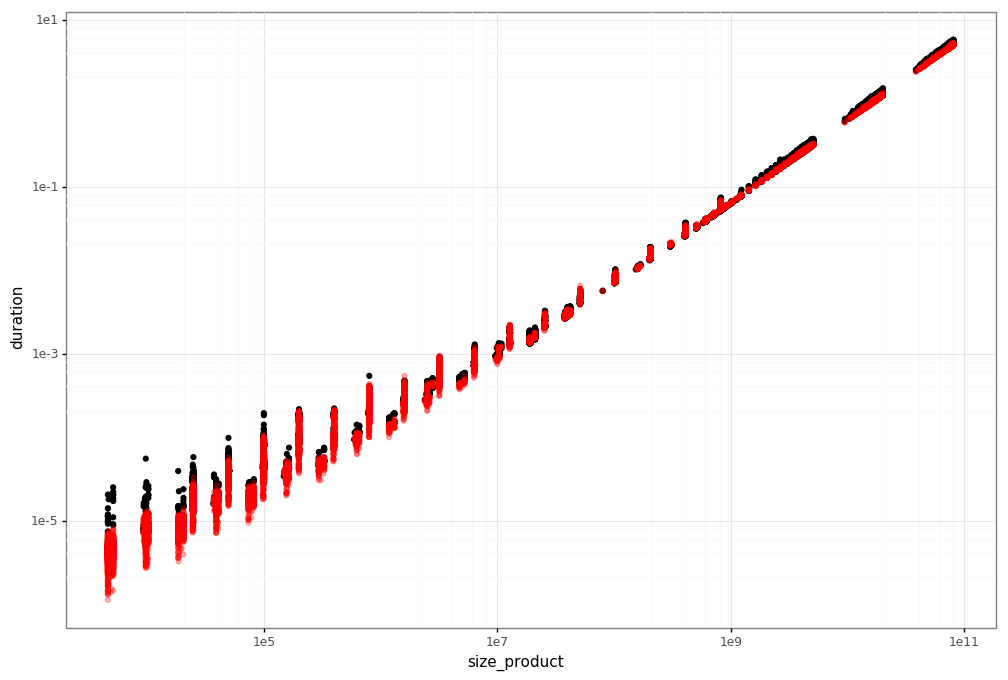

<ggplot: (-9223363279410594244)>


In [20]:
plot = ggplot(hpl_dgemm) + geom_point(aes(x='size_product', y='duration')) + geom_point(aes(x='size_product', y='pred_noise'), color='red', alpha=0.3) + theme_bw()
print(plot)
print(plot + scale_x_log10() + scale_y_log10())

### Checking that the calibration data is reasonably close to HPL data

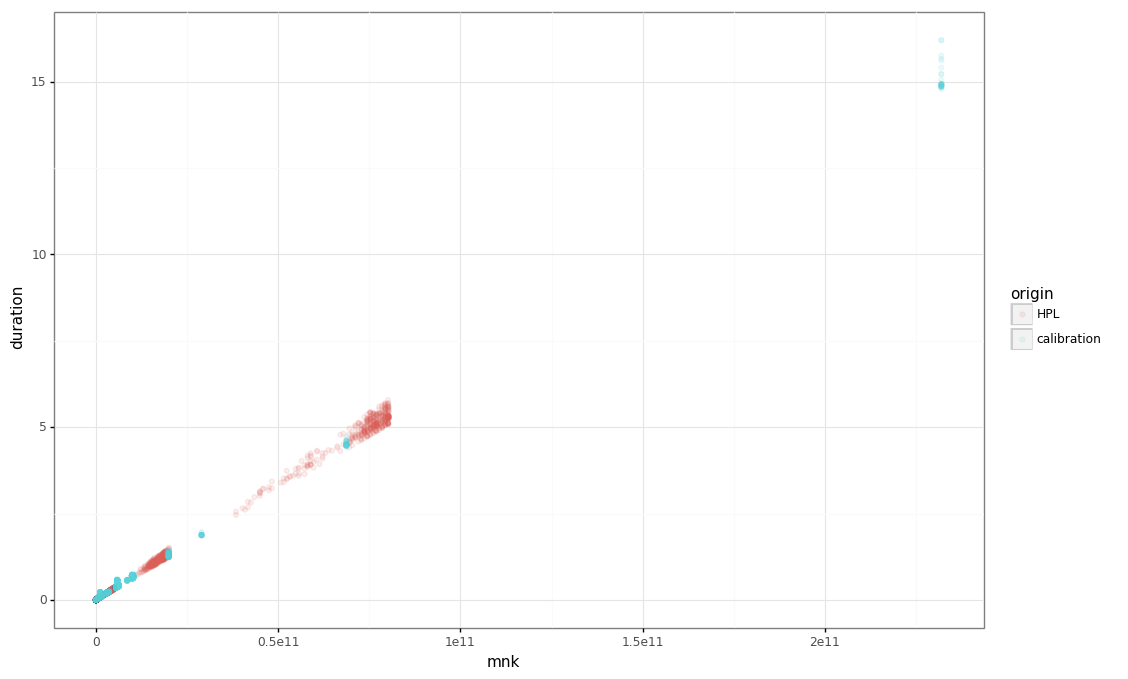

<ggplot: (8757444062896)>


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 31 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


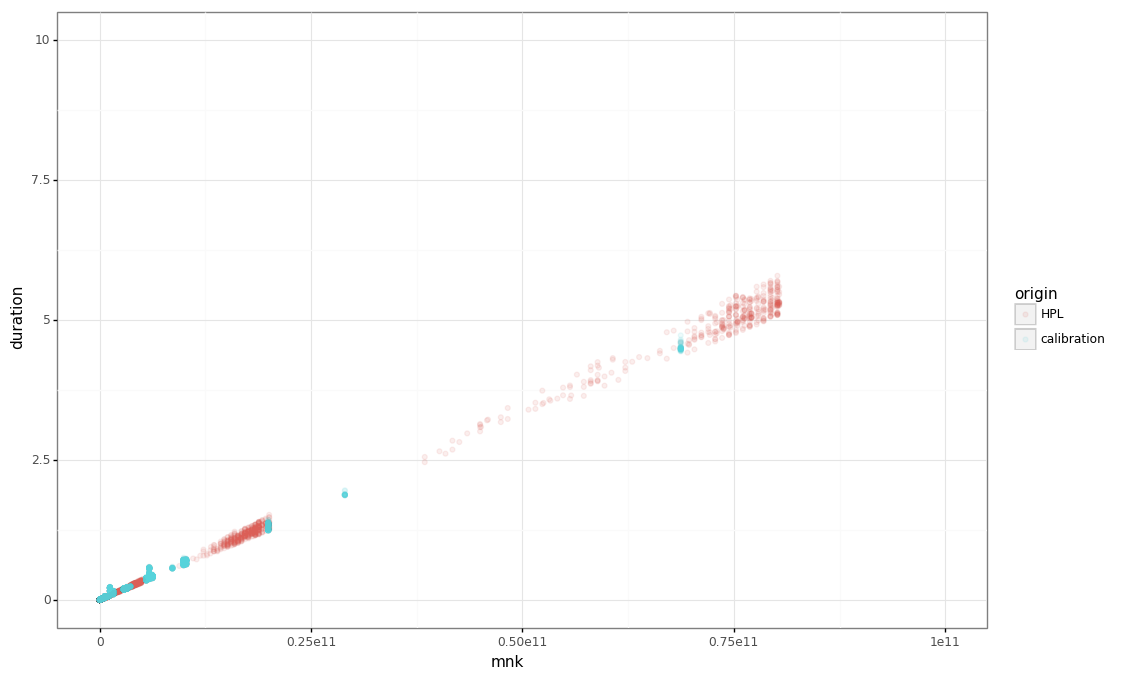

<ggplot: (-9223363279398106578)>


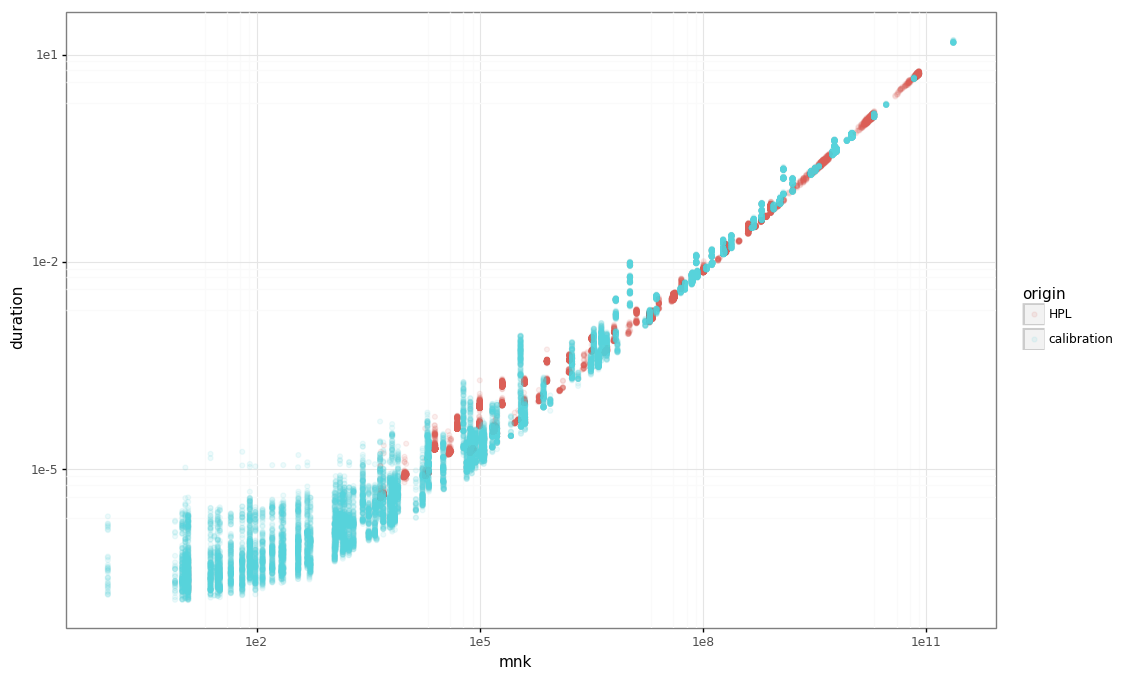

<ggplot: (8757456733402)>


In [21]:
df['origin'] = 'calibration'
hpl_dgemm['origin'] = 'HPL'
tmp = pandas.concat([hpl_dgemm.sample(n=20000), df.sample(n=20000)])
plot = ggplot(tmp) + geom_point(aes(x='mnk', y='duration', color='origin'), alpha=0.1) + theme_bw()
print(plot)
print(plot + xlim(0, 1e11) + ylim(0, 10))
print(plot + scale_x_log10() + scale_y_log10())

### Regression on HPL data

duration ~ mnk + 0
      mnk  duration
0  4608.0 -0.000001
1  4616.0 -0.000001
2  4632.0 -0.000001
3  4648.0 -0.000001
4  4664.0 -0.000001
                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.627e+06
Date:                Wed, 03 Apr 2019   Prob (F-statistic):               0.00
Time:                        09:52:50   Log-Likelihood:                 2324.8
No. Observations:                1077   AIC:                            -4648.
Df Residuals:                    1076   BIC:                            -4643.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025     

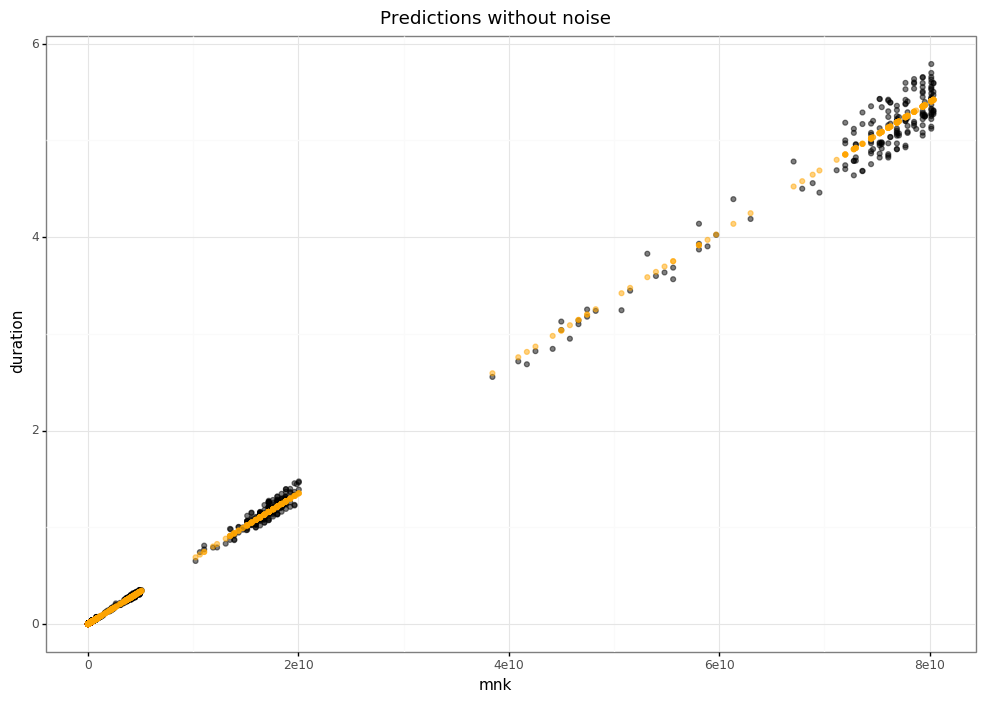

<ggplot: (8757456779868)>


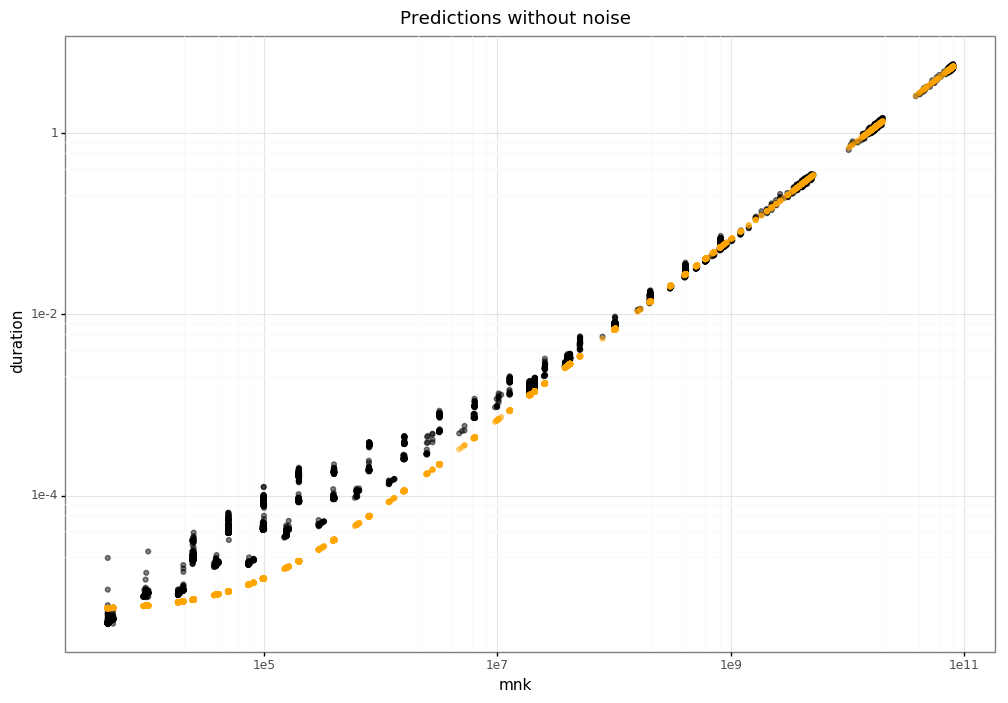

<ggplot: (8757443881192)>


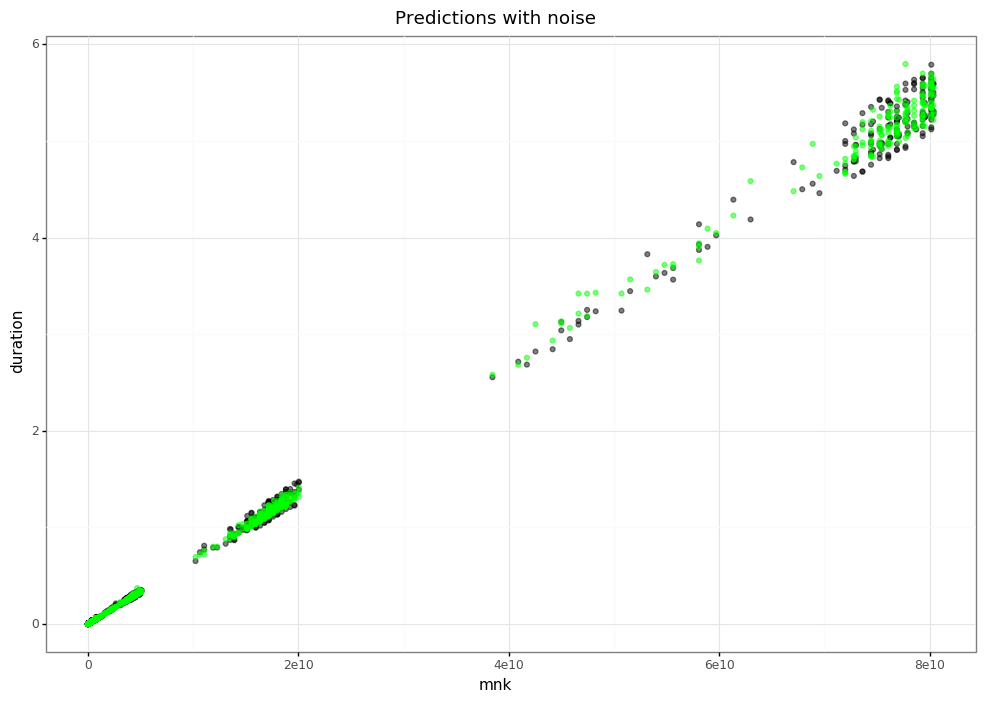

<ggplot: (8757443914311)>


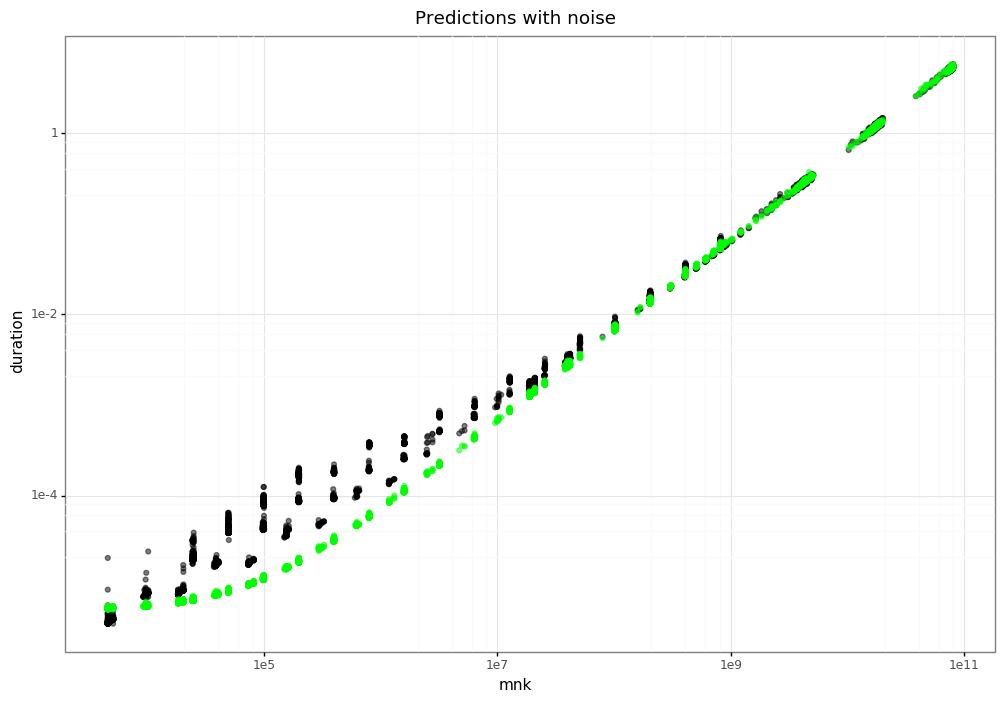

<ggplot: (-9223363279410825812)>


{'intercept': 5.408941760037349e-06,
 'mnk': 6.744785199154099e-11,
 'intercept_residual': 1.2255979150549734e-07,
 'mnk_residual': 2.0478012550938474e-12}

In [22]:
reg_hpl = compute_full_reg(hpl_dgemm, ['mnk'], draw_plot=True, verbose=True)
reg_hpl

In [23]:
reg_hpl_percpu = compute_reg_percpu(hpl_dgemm, ['mnk'])
pandas.DataFrame(reg_hpl_percpu)

,cpu,intercept,intercept_residual,mnk,mnk_residual,node
0,2,0.000004,0.000000,6.798571e-11,1.577815e-12,1
1,3,0.000012,0.000002,6.770436e-11,1.397041e-12,1
2,4,0.000011,0.000002,6.799894e-11,1.552890e-12,2
3,5,0.000004,0.000000,6.739465e-11,1.566166e-12,2
4,6,0.000004,0.000000,6.703762e-11,1.285498e-12,3
5,7,0.000012,0.000002,6.698047e-11,9.585591e-13,3
6,8,0.000013,0.000002,6.603067e-11,4.398501e-13,4
7,9,0.000004,0.000000,6.573081e-11,4.219828e-13,4
8,10,0.000004,0.000000,6.786426e-11,1.520238e-12,5
9,11,0.000011,0.000002,6.889168e-11,1.941884e-12,5


In [24]:
mean_reg_hpl = compute_mean_reg(reg_hpl_percpu)
mean_reg_hpl

{'cpu': 9.5,
 'intercept': 9.290139470513068e-06,
 'intercept_residual': 1.1661531309031935e-06,
 'mnk': 6.72758110965282e-11,
 'mnk_residual': 1.6783477981803078e-12,
 'node': 4.5}

Let's take an "optimistic" noise: the minimum intercept and coefficient for the residuals, between the global regression and the mean.

In [25]:
reg_hpl['mnk_residual'] = mean_reg_hpl['mnk_residual']
reg_hpl

{'intercept': 5.408941760037349e-06,
 'mnk': 6.744785199154099e-11,
 'intercept_residual': 1.2255979150549734e-07,
 'mnk_residual': 1.6783477981803078e-12}

### Mixing the calibration regression with HPL regression

In [26]:
for reg in [reg_local, reg_local_poly]:
    for reg_cpu in reg:
        reg_cpu['intercept_residual'] = reg_hpl['intercept_residual']
        reg_cpu['mnk_residual'] = reg_hpl['mnk_residual']

In [27]:
dump_reg(reg_local)

```c
double mu, sigma;
switch(get_cpuid()) {
    case 2: // node 1
        mu    = 5.403580e-07 + 6.749751e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 3: // node 1
        mu    = 5.220591e-07 + 6.442078e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 4: // node 2
        mu    = 5.276913e-07 + 6.622934e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 5: // node 2
        mu    = 5.192003e-07 + 6.479991e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 6: // node 3
        mu    = 5.228191e-07 + 6.596774e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 7: // node 3
        mu    = 5.071483e-07 + 6.423788e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 8: // node 4
        mu    = 5.182449e-07 + 6.436204e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 9: // node 4
        mu    = 5.176756e-07 + 6.433753e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 10: // node 5
        mu    = 5.127542e-07 + 6.590525e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 11: // node 5
        mu    = 5.362046e-07 + 6.403295e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 12: // node 6
        mu    = 5.409690e-07 + 6.759847e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 13: // node 6
        mu    = 5.032638e-07 + 6.394058e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 14: // node 7
        mu    = 5.298281e-07 + 6.477511e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 15: // node 7
        mu    = 4.937630e-07 + 6.370514e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 16: // node 8
        mu    = 5.441216e-07 + 6.638942e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 17: // node 8
        mu    = 5.000922e-07 + 6.441994e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 18: // node 9
        mu    = 5.145131e-07 + 6.424284e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 19: // node 9
        mu    = 5.049606e-07 + 6.434211e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 20: // node 10
        mu    = 5.222622e-07 + 6.430249e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 21: // node 10
        mu    = 5.240088e-07 + 6.435981e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 22: // node 11
        mu    = 5.027986e-07 + 6.413796e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 23: // node 11
        mu    = 5.418981e-07 + 6.620098e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 24: // node 12
        mu    = 5.221636e-07 + 6.433978e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 25: // node 12
        mu    = 5.256128e-07 + 6.402656e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 34: // node 17
        mu    = 5.290902e-07 + 6.709782e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 35: // node 17
        mu    = 5.222500e-07 + 6.434971e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 36: // node 18
        mu    = 5.446243e-07 + 6.679241e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 37: // node 18
        mu    = 4.973578e-07 + 6.423393e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 38: // node 19
        mu    = 5.089191e-07 + 6.447933e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 39: // node 19
        mu    = 5.322644e-07 + 6.453686e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 40: // node 20
        mu    = 5.020687e-07 + 6.452141e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 41: // node 20
        mu    = 5.361672e-07 + 6.451670e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 42: // node 21
        mu    = 5.300218e-07 + 6.448700e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 43: // node 21
        mu    = 5.249067e-07 + 6.432215e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 44: // node 22
        mu    = 5.165410e-07 + 6.438809e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 45: // node 22
        mu    = 5.150627e-07 + 6.488564e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 46: // node 23
        mu    = 5.039400e-07 + 6.445813e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 47: // node 23
        mu    = 5.168232e-07 + 6.412272e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 48: // node 24
        mu    = 5.151544e-07 + 6.460218e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 49: // node 24
        mu    = 5.078540e-07 + 6.410562e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 50: // node 25
        mu    = 5.451601e-07 + 6.942188e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 51: // node 25
        mu    = 4.997062e-07 + 6.398127e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 52: // node 26
        mu    = 5.143945e-07 + 6.458368e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 53: // node 26
        mu    = 5.274588e-07 + 6.544914e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 54: // node 27
        mu    = 5.258334e-07 + 6.520122e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 55: // node 27
        mu    = 5.332343e-07 + 6.567759e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 56: // node 28
        mu    = 5.429231e-07 + 6.713744e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 57: // node 28
        mu    = 5.134762e-07 + 6.416773e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 58: // node 29
        mu    = 5.167773e-07 + 6.420060e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 59: // node 29
        mu    = 5.163550e-07 + 6.427940e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 60: // node 30
        mu    = 5.174845e-07 + 6.425319e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 61: // node 30
        mu    = 5.115994e-07 + 6.416383e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 62: // node 31
        mu    = 5.186783e-07 + 6.422089e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 63: // node 31
        mu    = 5.122672e-07 + 6.432662e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 64: // node 32
        mu    = 5.136935e-07 + 6.396191e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 65: // node 32
        mu    = 5.062397e-07 + 6.412149e-11*mnk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    default:
        mu    = 3.407143e+01*cpu + 5.198703e-07 + 6.488607e-11*mnk + 1.678571e+01*node;
        sigma = 1.225598e-07 + 1.678348e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
}
```

In [28]:
dump_reg(reg_local_poly)

```c
double mu, sigma;
switch(get_cpuid()) {
    case 2: // node 1
        mu    = 5.393244e-07 + 6.679759e-11*mnk + -5.740287e-10*mn + 1.361118e-09*mk + 2.524071e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 1.009451e-10*mn + 1.347495e-10*mk + 9.457558e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 3: // node 1
        mu    = 5.228051e-07 + 6.355150e-11*mnk + -1.334303e-10*mn + 1.660894e-09*mk + 2.965415e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 1.976500e-11*mn + 5.622314e-11*mk + 5.870116e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 4: // node 2
        mu    = 5.329919e-07 + 6.547159e-11*mnk + -4.171307e-10*mn + 1.428695e-09*mk + 2.710319e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 1.152215e-11*mn + 4.975200e-11*mk + 1.887183e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 5: // node 2
        mu    = 5.262917e-07 + 6.392687e-11*mnk + -1.616727e-10*mn + 1.650467e-09*mk + 3.011181e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 1.792774e-11*mn + 5.265701e-11*mk + 6.082794e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 6: // node 3
        mu    = 5.305164e-07 + 6.518867e-11*mnk + -3.740277e-10*mn + 1.458767e-09*mk + 2.779049e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 1.189282e-11*mn + 4.741327e-11*mk + 2.357065e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 7: // node 3
        mu    = 5.136505e-07 + 6.335566e-11*mnk + -9.740071e-11*mn + 1.678005e-09*mk + 3.002629e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 3.339540e-11*mn + 5.059355e-11*mk + 5.858528e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 8: // node 4
        mu    = 5.230183e-07 + 6.349091e-11*mnk + -1.267585e-10*mn + 1.641870e-09*mk + 2.988689e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 1.344342e-11*mn + 4.505368e-11*mk + 5.126023e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 9: // node 4
        mu    = 5.268878e-07 + 6.345320e-11*mnk + -9.948909e-11*mn + 1.677894e-09*mk + 3.011612e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 1.953734e-11*mn + 4.503107e-11*mk + 6.347004e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 10: // node 5
        mu    = 5.190615e-07 + 6.509485e-11*mnk + -3.173703e-10*mn + 1.548433e-09*mk + 2.821357e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 2.361859e-11*mn + 7.380883e-11*mk + 2.018451e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 11: // node 5
        mu    = 5.322948e-07 + 6.316829e-11*mnk + -8.666260e-11*mn + 1.632169e-09*mk + 2.940922e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 2.645732e-11*mn + 5.564334e-11*mk + 6.106570e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 12: // node 6
        mu    = 5.491498e-07 + 6.680856e-11*mnk + -3.753763e-10*mn + 1.526969e-09*mk + 2.762434e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 1.094427e-10*mn + 1.206953e-10*mk + 1.335707e-10*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 13: // node 6
        mu    = 5.087136e-07 + 6.307483e-11*mnk + -8.990279e-11*mn + 1.624337e-09*mk + 2.954883e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 2.516824e-11*mn + 5.463920e-11*mk + 5.663861e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 14: // node 7
        mu    = 5.385376e-07 + 6.388876e-11*mnk + -1.085675e-10*mn + 1.675846e-09*mk + 3.031570e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 2.056132e-11*mn + 5.775322e-11*mk + 5.753924e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 15: // node 7
        mu    = 5.023913e-07 + 6.283385e-11*mnk + -7.262560e-11*mn + 1.620455e-09*mk + 2.983781e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 1.798127e-11*mn + 4.872682e-11*mk + 5.032753e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 16: // node 8
        mu    = 5.492241e-07 + 6.559519e-11*mnk + -3.770104e-10*mn + 1.502750e-09*mk + 2.812904e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 4.653663e-11*mn + 8.707011e-11*mk + 7.255564e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 17: // node 8
        mu    = 5.076557e-07 + 6.356987e-11*mnk + -1.366242e-10*mn + 1.606765e-09*mk + 2.910988e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 3.147357e-11*mn + 6.516342e-11*mk + 6.524439e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 18: // node 9
        mu    = 5.231685e-07 + 6.338601e-11*mnk + -1.199330e-10*mn + 1.610505e-09*mk + 2.934597e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 1.937225e-11*mn + 5.018231e-11*mk + 5.910065e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 19: // node 9
        mu    = 5.153587e-07 + 6.348720e-11*mnk + -1.204156e-10*mn + 1.616533e-09*mk + 2.919605e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 1.580925e-11*mn + 4.237050e-11*mk + 4.294049e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 20: // node 10
        mu    = 5.261699e-07 + 6.340284e-11*mnk + -7.340727e-11*mn + 1.700672e-09*mk + 3.057443e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 2.882459e-11*mn + 5.589685e-11*mk + 6.332054e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 21: // node 10
        mu    = 5.288127e-07 + 6.348381e-11*mnk + -1.028025e-10*mn + 1.654537e-09*mk + 2.993711e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 9.911284e-12*mn + 3.664809e-11*mk + 4.506676e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 22: // node 11
        mu    = 5.092075e-07 + 6.326350e-11*mnk + -1.004866e-10*mn + 1.643766e-09*mk + 2.990651e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 2.996774e-11*mn + 5.202909e-11*mk + 6.606632e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 23: // node 11
        mu    = 5.414760e-07 + 6.543216e-11*mnk + -4.190672e-10*mn + 1.443803e-09*mk + 2.748622e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 3.240033e-11*mn + 8.273599e-11*mk + 4.048271e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 24: // node 12
        mu    = 5.233135e-07 + 6.347770e-11*mnk + -1.191088e-10*mn + 1.609964e-09*mk + 2.962635e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 1.498512e-11*mn + 3.918575e-11*mk + 5.127312e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 25: // node 12
        mu    = 5.265666e-07 + 6.314147e-11*mnk + -7.996460e-11*mn + 1.666515e-09*mk + 3.016302e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 2.240832e-11*mn + 5.539865e-11*mk + 6.012762e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 34: // node 17
        mu    = 5.344454e-07 + 6.632775e-11*mnk + -4.274161e-10*mn + 1.470139e-09*mk + 2.724523e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 9.119124e-11*mn + 1.183724e-10*mk + 9.917033e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 35: // node 17
        mu    = 5.299293e-07 + 6.346425e-11*mnk + -1.259036e-10*mn + 1.688626e-09*mk + 3.017974e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 3.248806e-11*mn + 7.237567e-11*mk + 6.760120e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 36: // node 18
        mu    = 5.468983e-07 + 6.601110e-11*mnk + -3.807323e-10*mn + 1.516048e-09*mk + 2.725249e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 8.682976e-11*mn + 1.253534e-10*mk + 9.683318e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 37: // node 18
        mu    = 5.067599e-07 + 6.338941e-11*mnk + -1.350813e-10*mn + 1.585363e-09*mk + 2.898263e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 3.449688e-11*mn + 5.544574e-11*mk + 6.214726e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 38: // node 19
        mu    = 5.134214e-07 + 6.359606e-11*mnk + -9.901022e-11*mn + 1.663628e-09*mk + 3.018796e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 1.290475e-11*mn + 4.780033e-11*mk + 5.015694e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 39: // node 19
        mu    = 5.368837e-07 + 6.368006e-11*mnk + -1.479424e-10*mn + 1.619711e-09*mk + 2.943221e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 1.138776e-11*mn + 4.142007e-11*mk + 5.003563e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 40: // node 20
        mu    = 5.103642e-07 + 6.364136e-11*mnk + -1.178451e-10*mn + 1.662917e-09*mk + 3.007687e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 1.878462e-11*mn + 5.025264e-11*mk + 6.374513e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 41: // node 20
        mu    = 5.397179e-07 + 6.364649e-11*mnk + -1.123143e-10*mn + 1.636110e-09*mk + 2.979555e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 2.220993e-11*mn + 4.467521e-11*mk + 6.062142e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 42: // node 21
        mu    = 5.317256e-07 + 6.358211e-11*mnk + -9.284797e-11*mn + 1.704904e-09*mk + 3.090069e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 6.779641e-12*mn + 3.445108e-11*mk + 4.021661e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 43: // node 21
        mu    = 5.208321e-07 + 6.345914e-11*mnk + -1.326302e-10*mn + 1.636123e-09*mk + 2.953639e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 2.977270e-11*mn + 4.805156e-11*mk + 4.482061e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 44: // node 22
        mu    = 5.231029e-07 + 6.351977e-11*mnk + -1.002971e-10*mn + 1.636146e-09*mk + 2.961246e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 3.333609e-11*mn + 5.910749e-11*mk + 6.083720e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 45: // node 22
        mu    = 5.206402e-07 + 6.401250e-11*mnk + -1.391267e-10*mn + 1.648974e-09*mk + 2.997566e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 2.262201e-11*mn + 6.262390e-11*mk + 5.576603e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 46: // node 23
        mu    = 5.064498e-07 + 6.357593e-11*mnk + -1.127577e-10*mn + 1.665394e-09*mk + 3.018353e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 2.742789e-11*mn + 5.041331e-11*mk + 6.274031e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 47: // node 23
        mu    = 5.190310e-07 + 6.327078e-11*mnk + -1.248876e-10*mn + 1.598032e-09*mk + 2.924428e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 1.862309e-11*mn + 4.806724e-11*mk + 4.257829e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 48: // node 24
        mu    = 5.185796e-07 + 6.373260e-11*mnk + -1.265035e-10*mn + 1.636102e-09*mk + 2.981898e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 2.544243e-11*mn + 5.397706e-11*mk + 6.632500e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 49: // node 24
        mu    = 5.156076e-07 + 6.323151e-11*mnk + -8.437938e-11*mn + 1.645000e-09*mk + 2.975996e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 3.573403e-11*mn + 5.190488e-11*mk + 6.109547e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 50: // node 25
        mu    = 5.552318e-07 + 6.861468e-11*mnk + -3.886047e-10*mn + 1.558966e-09*mk + 2.812087e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 1.124913e-10*mn + 1.229869e-10*mk + 1.540899e-10*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 51: // node 25
        mu    = 5.071344e-07 + 6.314591e-11*mnk + -1.394035e-10*mn + 1.555916e-09*mk + 2.884728e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 1.235565e-11*mn + 4.115298e-11*mk + 3.147907e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 52: // node 26
        mu    = 5.220811e-07 + 6.371916e-11*mnk + -1.606740e-10*mn + 1.626739e-09*mk + 2.978407e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 1.807460e-11*mn + 5.077949e-11*mk + 5.385897e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 53: // node 26
        mu    = 5.305365e-07 + 6.465317e-11*mnk + -3.202027e-10*mn + 1.499278e-09*mk + 2.807434e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + -1.894556e-11*mn + 2.097636e-11*mk + -1.678183e-12*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 54: // node 27
        mu    = 5.365141e-07 + 6.436760e-11*mnk + -2.587134e-10*mn + 1.593261e-09*mk + 2.889037e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 1.103735e-11*mn + 5.334813e-11*mk + 4.773279e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 55: // node 27
        mu    = 5.276706e-07 + 6.489361e-11*mnk + -3.601891e-10*mn + 1.483759e-09*mk + 2.775141e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + -6.907262e-13*mn + 5.045010e-11*mk + 9.056070e-12*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 56: // node 28
        mu    = 5.420053e-07 + 6.639338e-11*mnk + -4.974038e-10*mn + 1.459098e-09*mk + 2.628189e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 8.780899e-11*mn + 1.246792e-10*mk + 1.119746e-10*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 57: // node 28
        mu    = 5.149328e-07 + 6.328837e-11*mnk + -9.665357e-11*mn + 1.646485e-09*mk + 3.013190e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 2.461958e-11*mn + 5.148661e-11*mk + 4.889745e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 58: // node 29
        mu    = 5.255900e-07 + 6.331282e-11*mnk + -6.500140e-11*mn + 1.688902e-09*mk + 3.001173e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 3.061241e-11*mn + 4.846374e-11*mk + 5.632437e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 59: // node 29
        mu    = 5.208931e-07 + 6.339989e-11*mnk + -1.045580e-10*mn + 1.645969e-09*mk + 3.019445e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 2.656993e-11*mn + 5.149211e-11*mk + 5.389626e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 60: // node 30
        mu    = 5.265286e-07 + 6.337573e-11*mnk + -7.189099e-11*mn + 1.656573e-09*mk + 2.979553e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 1.316460e-11*mn + 4.184614e-11*mk + 5.221730e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 61: // node 30
        mu    = 5.145376e-07 + 6.328963e-11*mnk + -1.051588e-10*mn + 1.635049e-09*mk + 3.000886e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 2.836230e-11*mn + 5.204211e-11*mk + 6.824112e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 62: // node 31
        mu    = 5.255507e-07 + 6.336915e-11*mnk + -1.155430e-10*mn + 1.603461e-09*mk + 2.916228e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 1.780135e-11*mn + 4.575905e-11*mk + 4.315604e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 63: // node 31
        mu    = 5.203696e-07 + 6.345565e-11*mnk + -9.089474e-11*mn + 1.650291e-09*mk + 2.961259e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 1.293906e-11*mn + 4.133834e-11*mk + 4.200090e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 64: // node 32
        mu    = 5.231576e-07 + 6.307634e-11*mnk + -4.793847e-11*mn + 1.653379e-09*mk + 3.015021e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 2.488421e-11*mn + 4.040013e-11*mk + 5.981118e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 65: // node 32
        mu    = 5.114425e-07 + 6.325749e-11*mnk + -7.866192e-11*mn + 1.629375e-09*mk + 2.938603e-09*nk;
        sigma = 1.225598e-07 + 1.678348e-12*mnk + 2.490204e-11*mn + 4.602318e-11*mk + 4.618505e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    default:
        mu    = 3.407143e+01*cpu + 5.249134e-07 + 1.604311e-09*mk + -1.793648e-10*mn + 6.403747e-11*mnk + 2.922754e-09*nk + 1.678571e+01*node;
        sigma = 1.225598e-07 + 5.905245e-11*mk + 2.927438e-11*mn + 1.678348e-12*mnk + 5.780894e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
}
```

### Validation for this hybrid calibration (linear model)

In [29]:
compute_predictions(hpl_dgemm, reg_local, ['mnk'])
hpl_dgemm.head()

,file,line,function,rank,timestamp,duration,m,n,k,origin,...,nk,core,node,cpu,prediction,sd_noise,sigma,mu,noise,pred_noise
13,../HPL_pdrpanrlT.c,224,dgemm,0,14.47309,0.000200,50046.0,2.0,2.0,HPL,...,4.0,0,1,2,0.000014,4.585382e-07,7.606675e-07,-6.069248e-07,-3.196032e-07,0.000014
29,../HPL_pdrpanrlT.c,224,dgemm,0,14.47358,0.000380,50044.0,4.0,4.0,HPL,...,16.0,0,1,2,0.000055,1.466420e-06,2.432639e-06,-1.940965e-06,-3.114242e-07,0.000054
43,../HPL_pdrpanrlT.c,224,dgemm,0,14.47421,0.000166,50042.0,2.0,2.0,HPL,...,4.0,0,1,2,0.000014,4.585113e-07,7.606229e-07,-6.068893e-07,-4.467093e-07,0.000014
66,../HPL_pdrpanrlT.c,224,dgemm,0,14.47468,0.000751,50040.0,8.0,8.0,HPL,...,64.0,0,1,2,0.000217,5.497569e-06,9.119900e-06,-7.276627e-06,-2.265335e-06,0.000214
81,../HPL_pdrpanrlT.c,224,dgemm,0,14.47579,0.000177,50038.0,2.0,2.0,HPL,...,4.0,0,1,2,0.000014,4.584845e-07,7.605784e-07,-6.068537e-07,7.345765e-07,0.000015


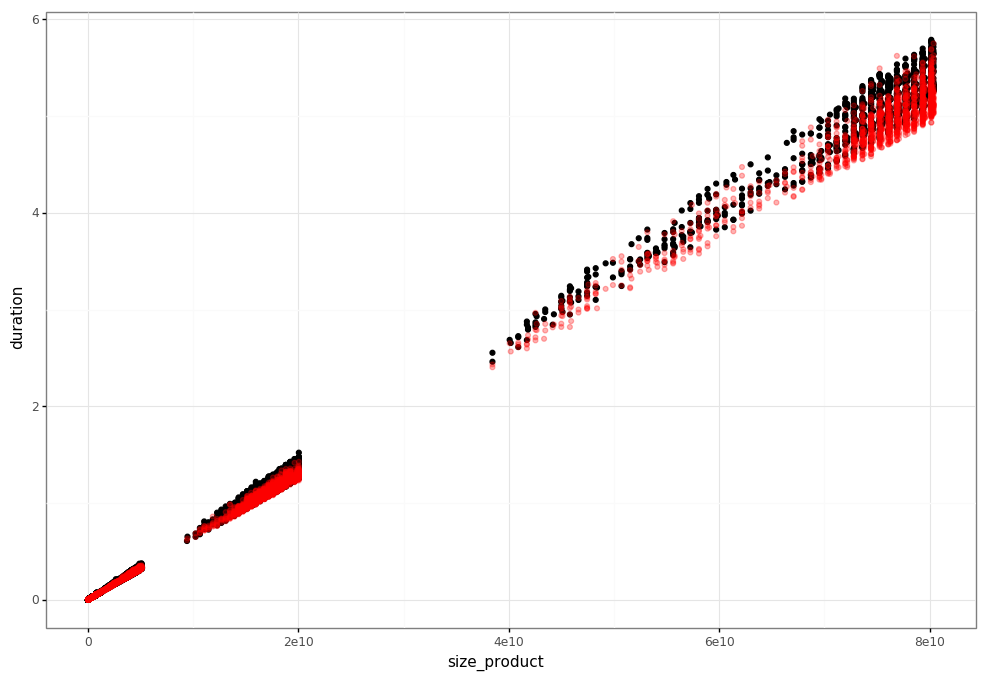

<ggplot: (8757446455574)>


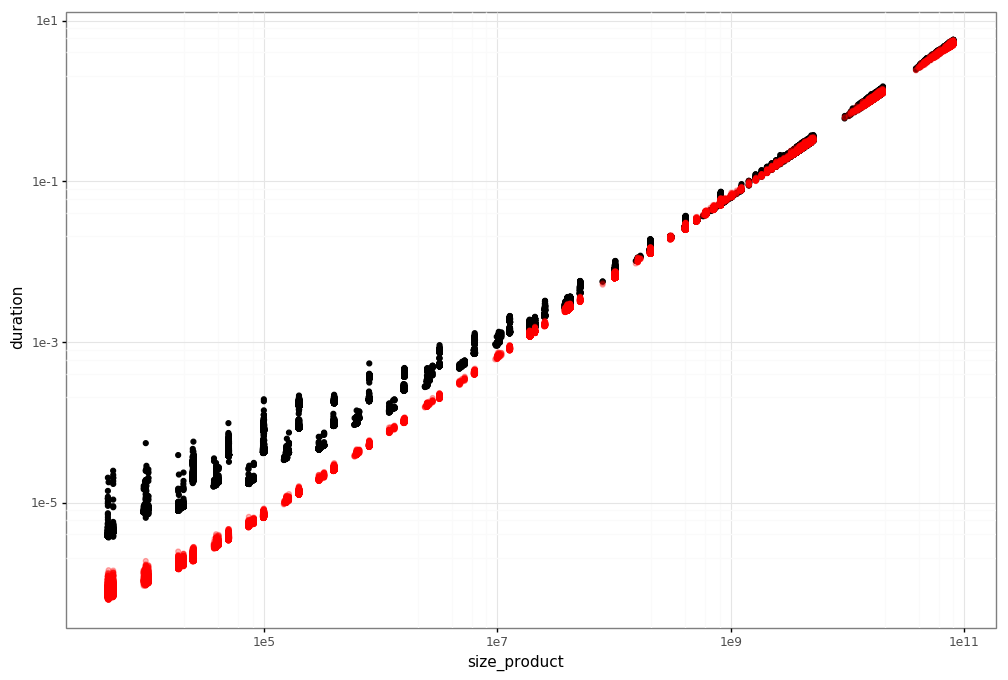

<ggplot: (8757443944596)>


In [30]:
plot = ggplot(hpl_dgemm) + geom_point(aes(x='size_product', y='duration')) + geom_point(aes(x='size_product', y='pred_noise'), color='red', alpha=0.3) + theme_bw()
print(plot)
print(plot + scale_x_log10() + scale_y_log10())

### Validation for this hybrid calibration (polynomial model)

In [31]:
compute_predictions(hpl_dgemm, reg_local_poly, ['mnk', 'mn', 'mk', 'nk'])
hpl_dgemm.head()

,file,line,function,rank,timestamp,duration,m,n,k,origin,...,nk,core,node,cpu,prediction,sd_noise,sigma,mu,noise,pred_noise
13,../HPL_pdrpanrlT.c,224,dgemm,0,14.47309,0.000200,50046.0,2.0,2.0,HPL,...,4.0,0,1,2,0.000093,0.000024,0.000040,-0.000032,0.000002,0.000095
29,../HPL_pdrpanrlT.c,224,dgemm,0,14.47358,0.000380,50044.0,4.0,4.0,HPL,...,16.0,0,1,2,0.000212,0.000049,0.000081,-0.000064,-0.000020,0.000192
43,../HPL_pdrpanrlT.c,224,dgemm,0,14.47421,0.000166,50042.0,2.0,2.0,HPL,...,4.0,0,1,2,0.000093,0.000024,0.000040,-0.000032,0.000004,0.000097
66,../HPL_pdrpanrlT.c,224,dgemm,0,14.47468,0.000751,50040.0,8.0,8.0,HPL,...,64.0,0,1,2,0.000530,0.000100,0.000166,-0.000132,-0.000063,0.000466
81,../HPL_pdrpanrlT.c,224,dgemm,0,14.47579,0.000177,50038.0,2.0,2.0,HPL,...,4.0,0,1,2,0.000093,0.000024,0.000040,-0.000032,-0.000032,0.000061


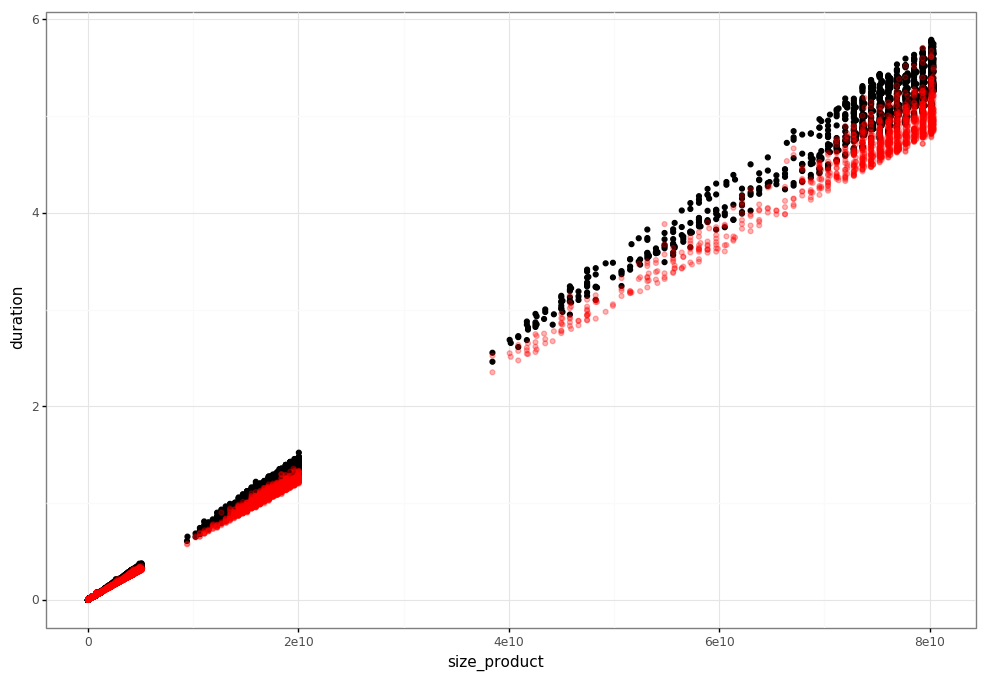

<ggplot: (8757443944505)>


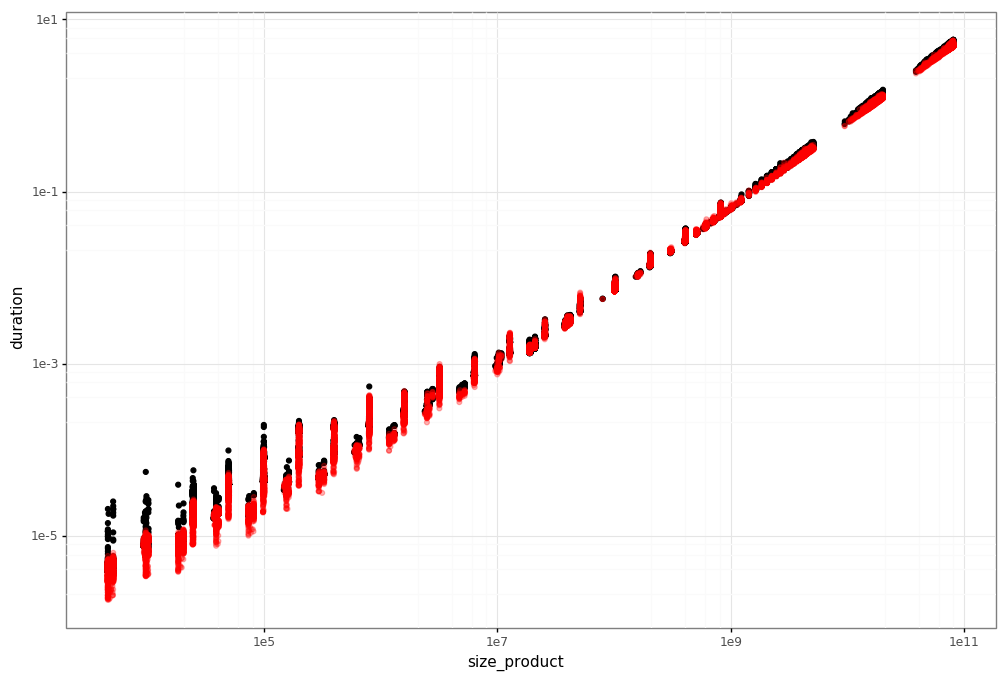

<ggplot: (-9223363279410756036)>


In [32]:
plot = ggplot(hpl_dgemm) + geom_point(aes(x='size_product', y='duration')) + geom_point(aes(x='size_product', y='pred_noise'), color='red', alpha=0.3) + theme_bw()
print(plot)
print(plot + scale_x_log10() + scale_y_log10())